# Predicting the National Hockey League's Norris Trophy Voting

It's no question that professional sports are a major deal around the globe.  Within that domain, one particular area of intrigue is professional sports awards; notably those "best of" awards driven by voting (American college football's Heisman trophy, FIFA's Ballon d'Or, and MLB's Gold Glove award being a couple of examples).  The National Hockey League (NHL) is one example of a professional league with its own set of awards; it sees regular season- and playoffs-related awards given on a season-by-season basis.

Of particular interest is the James Norris Trophy, awarded each season “to the defense player who demonstrates throughout the season the greatest all-round ability in the position" (see: [the NHL's official Norris Trophy page](https://records.nhl.com/awards/trophies/james-norris-memorial-trophy)).  What is especially interesting about the Norris Trophy is that it has long been the award most associated with ambiguity/controversy as to what exactly winning it ought to be based on (see [this article](http://everythinghockey.xhockeyproducts.com/2017/03/james-norris-trophy-offense-defense/) for a closer look into this controversy, and how what criteria seem to matter most has changed over time).

Nevertheless; in this project, we'll attempt to use statistical data from past NHL seasons, as well as past Norris Trophy voting data, to train a model geared towards predicting the current season's winner.  Due to the NHL's response to the Covid-19 outbreak, the 2019-2020 season was suspended in March, with the final games having been played on March 11, 2020.  For some time, it was unclear as to whether the season would resume.  In late May, an official announcement was made that the league's regular season was officially over, and plans for a playoff were being discussed.  Given that, the current regular season can be regarded as "complete," and the Norris Trophy, among other regular season-based awards, can be addressed.

*Note:* Our goal in this project is not to extensively pursue the absolute best possible performing algorithm or hyperparameter values, but rather to demonstrate going through a full data science workflow (starting with data collection, aggregation, and cleaning) and landing on a reasonably well-performing model that we can use to make an initial prediction.

## Pulling In The Data

For this project, we've acquired our data from [Hockey-Reference.com](http://www.hockey-reference.com); an established, well-structured and comprehensive collection of NHL-related data covering the lifespan of the league.  One of the core ways the site organizes data is season-by-season.

For each season, we've collected three separate sets of data:
- `skater_stats`, which contains individual player statistical data (i.e. goals, assists, etc.)
- `season_standings`, which contains data on teams in league standings
- `norris_voting`, which contains data on Norris Trophy voting outcomes

Altogether, our data begins in the 1979-1980 season.  While this is well into the history of the league, the reasons we've chosen this as the starting point for our data include:
- it still provides us 40 years of data to work with
- it falls within an era of the league where the game (and, in particular, the defense position) was changing
- it was an expansion year, which saw the league expand to 21 teams
- prior seasons appear to be more prone to missing values for important stats
- it was Wayne Gretzky's (arguably the greatest player to ever play in the NHL, and someone who drew a ton of attention to the sport) rookie season

We've already collected our data into three sets of CSV files, each representing one season's worth of one of the subsets.  We'll first create a list of strings representing our season values.  It will exclude the 2004-2005 season, as that one never took place due to a lockout.

In [1]:
import warnings
warnings.filterwarnings('ignore') # hide majority of Python warnings that may come up along the way
import pandas as pd
pd.set_option('display.max_columns', None) # allows us to view all columns in a dataframe, even if it requires side-scrolling

# create list of season values
seasons = []

for i in range(79, 99):
    seasons.append("19" + str(i) + "19" + str(i + 1))

seasons.append("19992000")

for i in range(0, 20):
    first = str(i).zfill(2)
    second = str(i + 1).zfill(2)
    season = "20" + first + "20" + second
    
    if season != "20042005": # leave out 04-05, as a lockout caused a total loss of that season
        seasons.append("20" + first + "20" + second)
    
seasons

['19791980',
 '19801981',
 '19811982',
 '19821983',
 '19831984',
 '19841985',
 '19851986',
 '19861987',
 '19871988',
 '19881989',
 '19891990',
 '19901991',
 '19911992',
 '19921993',
 '19931994',
 '19941995',
 '19951996',
 '19961997',
 '19971998',
 '19981999',
 '19992000',
 '20002001',
 '20012002',
 '20022003',
 '20032004',
 '20052006',
 '20062007',
 '20072008',
 '20082009',
 '20092010',
 '20102011',
 '20112012',
 '20122013',
 '20132014',
 '20142015',
 '20152016',
 '20162017',
 '20172018',
 '20182019',
 '20192020']

Now let's read in each of our CSV files and combine all seasons together into one dataframe for each subset of data (skater stats, league standings, Norris voting).  We'll still be able to filter by season as needed given the creation of a `season` column in each dataframe.

*Note:* The number of individual season voting data dataframes should be one short of the number of skater stats and league standings dataframes, given that voting for the current season has not yet occurred/been reported.

In [2]:
standings_prefix = "season_standings_"
skater_stats_prefix = "skater_stats_"
norris_voting_prefix = "norris_voting_"

standings_dfs = []
skater_stats_dfs = []
voting_dfs = []

def create_dataframes(season):
    standings_df = pd.read_csv("season_standings/season_standings_" + season + ".csv")
    standings_df["season"] = season
    skater_stats_df = pd.read_csv("skater_stats/skater_stats_" + season + ".csv")
    skater_stats_df["season"] = season
    # for voting data, there's none for current, suspended season - skip it
    try:
        voting_df = pd.read_csv("norris_voting/norris_voting_" + season + ".csv")
        voting_df["season"] = season
    except:
        pass
        
    standings_dfs.append(standings_df)
    skater_stats_dfs.append(skater_stats_df)
    try:
        voting_dfs.append(voting_df)
    except:
        pass
    
for season in seasons:
    create_dataframes(season)


In [3]:
# double-check how many individual season standings dataframes we've created
len(standings_dfs)

40

In [4]:
# double-check how many individual season skater stats dataframes we've created
len(skater_stats_dfs)

40

In [5]:
# double-check how many individual season Norris Trophy voting dataframes we've created
len(voting_dfs)

39

In [6]:
# combine all seasons for each subset of data
standings_data = pd.concat(standings_dfs).reset_index(drop=True)
skater_stats_data = pd.concat(skater_stats_dfs).reset_index(drop=True)
voting_data = pd.concat(voting_dfs).reset_index(drop=True)

Now let's quickly take a look at the length of each aggregate dataframe we've created and the first five rows of each.

In [7]:
print(standings_data.shape[0])
standings_data.head()

1056


,Team,GP,W,L,OL,PTS,PTS%,GF,GA,SRS,SOS,RPt%,RW,RgRec,RgPt%,season
0,Philadelphia Flyers*,80,48,12,20,116,0.725,327,254,0.87,-0.04,NaN,NaN,NaN,NaN,19791980
1,New York Islanders*,80,39,28,13,91,0.569,281,247,0.41,-0.02,NaN,NaN,NaN,NaN,19791980
2,New York Rangers*,80,38,32,10,86,0.538,308,284,0.29,-0.01,NaN,NaN,NaN,NaN,19791980
3,Atlanta Flames*,80,35,32,13,83,0.519,282,269,0.16,-0.01,NaN,NaN,NaN,NaN,19791980
4,Washington Capitals,80,27,40,13,67,0.419,261,293,-0.38,0.02,NaN,NaN,NaN,NaN,19791980


In [8]:
print(skater_stats_data.shape[0])
skater_stats_data.head()

37107


,Rk,Player,Age,Tm,Pos,GP,G,A,PTS,PLUSMINUS,PIM,PS,EV,PP,SH,GW,EV.1,PP.1,SH.1,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,season
0,110,Marcel Dionne*,28,LAK,C,80,53,84,137,34,32,13.5,36,17,0,6,55,29,0,348,15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
1,176,Wayne Gretzky*,19,EDM,C,79,51,86,137,14,21,12.6,37,13,1,6,63,22,1,284,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
2,268,Guy Lafleur*,28,MTL,RW,74,50,75,125,40,12,12.8,35,15,0,7,49,26,0,323,15.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
3,414,Gilbert Perreault*,29,BUF,C,80,40,66,106,33,57,9.9,30,10,0,5,37,29,0,180,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
4,458,Mike Rogers,25,HAR,C,80,44,61,105,28,10,9.9,39,3,2,0,42,19,0,229,19.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980


In [9]:
print(voting_data.shape[0])
voting_data.head()

639


,Place,Player,Age,Tm,Pos,Votes,Vote%,1st,2nd,3rd,4th,5th,G,A,PTS,PLUSMINUS,OPS,DPS,GPS,PS,season
0,1,Larry Robinson,28,MTL,D,239,46.41,NaN,NaN,NaN,NaN,NaN,14,61,75,38,5.5,5.9,0,11.4,19791980
1,2,Borje Salming,28,TOR,D,117,22.72,NaN,NaN,NaN,NaN,NaN,19,52,71,3,5.5,3.5,0,9.0,19791980
2,3,Jim Schoenfeld,27,BUF,D,85,16.50,NaN,NaN,NaN,NaN,NaN,9,27,36,60,1.9,7.7,0,9.7,19791980
3,4,Ray Bourque,19,BOS,D,51,9.90,NaN,NaN,NaN,NaN,NaN,17,48,65,52,4.7,7.1,0,11.8,19791980
4,5,Mark Howe,24,HAR,D,23,4.47,NaN,NaN,NaN,NaN,NaN,24,56,80,14,6.5,3.6,0,10.1,19791980


## Modifying & Cleaning the Dataframes: Pre-Merge

Now that we've created out three separate dataframes representing all seasons (dating back to the 79-80 season) of league standings, skater stats, and Norris Trophy voting data, let's dive into some data cleaning for each before we work on merging the 3 together.

### Cleaning/Editing Team & Player Names

Let's start out by cleaning up team and player names in our dataframes.

First, we'll eliminate any asterisks at the end of player names (which only served to signify the presence of a footnote on Hockey-Reference.com).

In [10]:
standings_data["Team"] = standings_data["Team"].str.replace("*", "")
skater_stats_data["Player"] = skater_stats_data["Player"].str.replace("*", "")
voting_data["Player"] = voting_data["Player"].str.replace("*", "")

Now let's take a look at how all of the team names are represented, in case anything needs fixing.

In [11]:
standings_data["Team"].unique()

array(['Philadelphia Flyers', 'New York Islanders', 'New York Rangers',
       'Atlanta Flames', 'Washington Capitals', 'Chicago Black Hawks',
       'St. Louis Blues', 'Vancouver Canucks', 'Edmonton Oilers',
       'Winnipeg Jets', 'Colorado Rockies', 'Buffalo Sabres',
       'Boston Bruins', 'Minnesota North Stars', 'Toronto Maple Leafs',
       'Quebec Nordiques', 'Montreal Canadiens', 'Los Angeles Kings',
       'Pittsburgh Penguins', 'Hartford Whalers', 'Detroit Red Wings',
       'Calgary Flames', 'New Jersey Devils', 'innesota North Stars',
       'hicago Black Hawks', 'Chicago Blackhawks', 'San Jose Sharks',
       'Tampa Bay Lightning', 'Ottawa Senators', 'Florida Panthers',
       'Dallas Stars', 'Mighty Ducks of Anaheim', 'hiladelphia Flyers',
       'Colorado Avalanche', 'Phoenix Coyotes', 'Carolina Hurricanes',
       'Nashville Predators', 'Atlanta Thrashers',
       'Columbus Blue Jackets', 'Minnesota Wild', 'ew Jersey Devils',
       'Anaheim Ducks', 'ontreal Canadiens'

We can see that there are a few teams whose names are missing letters.  Let's fix that by replacing the full name values with the correct ones.

While we're modifying team names, one specific modification we'll also want to make relates to the Winnipeg Jets.  The Winnipeg Jets existed as a franchise for a number of years before being relocated and renamed to the Phoenix Coyotes after the 1995-1996 season.  However, prior to the 2011-2012 season, the Atlanta Thrashers franchise was relocated to Winnipeg and renamed, reusing the Winnipeg Jets name (but technically being a completely different franchise, and being represented differently in standings data).  Thus, we'll want to differentiate, so we'll use `(New)` and `(Original)` suffixes to do so.

We'll handle "same team, modified name" scenarios a little later.

In [12]:
replace_values = {
        "ampa Bay Lightning": "Tampa Bay Lightning",
        "ew Jersey Devils": "New Jersey Devils",
        "hicago Black Hawks": "Chicago Black Hawks",
        "hiladelphia Flyers": "Philadelphia Flyers",
        "innesota North Stars": "Minnesota North Stars",
        "ontreal Canadiens": "Montreal Canadiens",
        "orida Panthers": "Florida Panthers"
    }

standings_data = standings_data.replace({"Team": replace_values})

# fix Jets rows to distinguish old org from new
def replace_jets(row):
    if row["Team"] == "Winnipeg Jets":
        if row["season"] in seasons[-9:]: # for seasons 20112012 and later
            row["Team"] = "Winnipeg Jets (New)"
        else:
            row["Team"] = "Winnipeg Jets (Original)"
    
    return row

standings_data = standings_data.apply(replace_jets, axis=1)

In [13]:
# check all the team name values now
print(len(standings_data["Team"].unique()))
standings_data["Team"].unique()

41


array(['Philadelphia Flyers', 'New York Islanders', 'New York Rangers',
       'Atlanta Flames', 'Washington Capitals', 'Chicago Black Hawks',
       'St. Louis Blues', 'Vancouver Canucks', 'Edmonton Oilers',
       'Winnipeg Jets (Original)', 'Colorado Rockies', 'Buffalo Sabres',
       'Boston Bruins', 'Minnesota North Stars', 'Toronto Maple Leafs',
       'Quebec Nordiques', 'Montreal Canadiens', 'Los Angeles Kings',
       'Pittsburgh Penguins', 'Hartford Whalers', 'Detroit Red Wings',
       'Calgary Flames', 'New Jersey Devils', 'Chicago Blackhawks',
       'San Jose Sharks', 'Tampa Bay Lightning', 'Ottawa Senators',
       'Florida Panthers', 'Dallas Stars', 'Mighty Ducks of Anaheim',
       'Colorado Avalanche', 'Phoenix Coyotes', 'Carolina Hurricanes',
       'Nashville Predators', 'Atlanta Thrashers',
       'Columbus Blue Jackets', 'Minnesota Wild', 'Anaheim Ducks',
       'Winnipeg Jets (New)', 'Arizona Coyotes', 'Vegas Golden Knights'],
      dtype=object)

### Converting Team Names to Abbreviations in Standings Data

In order to merge our league standings data with player data, we'll want to substitute team abbreviations for team names in the standings data.  Let's double-check all of the unique team abbreviation values from our skater data.

In [14]:
print(len(skater_stats_data["Tm"].unique()))
skater_stats_data["Tm"].unique()

42


array(['LAK', 'EDM', 'MTL', 'BUF', 'HAR', 'NYI', 'TOR', 'STL', 'MNS',
       'ATF', 'BOS', 'QUE', 'DET', 'TOT', 'PHI', 'NYR', 'VAN', 'WIN',
       'CBH', 'WSH', 'CLR', 'PIT', 'CGY', 'NJD', 'CHI', 'SJS', 'TBL',
       'OTT', 'DAL', 'FLA', 'MDA', 'COL', 'PHX', 'CAR', 'NSH', 'ATL',
       'CBJ', 'MIN', 'ANA', 'WPG', 'ARI', 'VEG'], dtype=object)

We're able to see team abbreviations associated with each of the team names above, with the addition of the `TOT` abbreviation (which represents "Total" and is used for players who played with more than one team in a season \[i.e. they were traded mid-season\], and will be addressed a little later).

Of particular note is the two different abbrevations for the Winnipeg Jets; one representing the original franchise (`WIN`), and one representing the new franchise (`WPG`).

Let's create a dictionary to map each team name to the associated abbreviation in order to make our substitution.

In [15]:
# dictionary of all associations between team names and abbreviations in our data
team_abbrevs = {
    "Anaheim Ducks": "ANA",
    "Arizona Coyotes": "ARI",
    "Atlanta Flames": "ATF",
    "Atlanta Thrashers": "ATL",
    "Boston Bruins": "BOS",
    "Buffalo Sabres": "BUF",
    "Carolina Hurricanes": "CAR",
    "Chicago Black Hawks": "CBH",
    "Columbus Blue Jackets": "CBJ",
    "Calgary Flames": "CGY",
    "Chicago Blackhawks": "CHI",
    "Colorado Rockies": "CLR",
    "Colorado Avalanche": "COL",
    "Dallas Stars": "DAL",
    "Detroit Red Wings": "DET",
    "Edmonton Oilers": "EDM",
    "Florida Panthers": "FLA",
    "Hartford Whalers": "HAR",
    "Los Angeles Kings": "LAK",
    "Mighty Ducks of Anaheim": "MDA",
    "Minnesota Wild": "MIN",
    "Minnesota North Stars": "MNS",
    "Montreal Canadiens": "MTL",
    "New Jersey Devils": "NJD",
    "Nashville Predators": "NSH",
    "New York Islanders": "NYI",
    "New York Rangers": "NYR",
    "Ottawa Senators": "OTT",
    "Philadelphia Flyers": "PHI",
    "Phoenix Coyotes": "PHX",
    "Pittsburgh Penguins": "PIT",
    "Quebec Nordiques": "QUE",
    "San Jose Sharks": "SJS",
    "St. Louis Blues": "STL",
    "Tampa Bay Lightning": "TBL",
    "Toronto Maple Leafs": "TOR",
    "Vancouver Canucks": "VAN",
    "Vegas Golden Knights": "VEG",
    "Winnipeg Jets (Original)": "WIN",
    "Winnipeg Jets (New)": "WPG",
    "Washington Capitals": "WSH"
}

In [16]:
# replace team names with associated abbreviations in the standings_data dataframe
standings_data["Team"] = standings_data["Team"].replace(team_abbrevs)

In [17]:
standings_data.head()

,Team,GP,W,L,OL,PTS,PTS%,GF,GA,SRS,SOS,RPt%,RW,RgRec,RgPt%,season
0,PHI,80,48,12,20,116,0.725,327,254,0.87,-0.04,NaN,NaN,NaN,NaN,19791980
1,NYI,80,39,28,13,91,0.569,281,247,0.41,-0.02,NaN,NaN,NaN,NaN,19791980
2,NYR,80,38,32,10,86,0.538,308,284,0.29,-0.01,NaN,NaN,NaN,NaN,19791980
3,ATF,80,35,32,13,83,0.519,282,269,0.16,-0.01,NaN,NaN,NaN,NaN,19791980
4,WSH,80,27,40,13,67,0.419,261,293,-0.38,0.02,NaN,NaN,NaN,NaN,19791980


We can see that the dataframe appears to now correctly list team abbreviations in the `Team` column.  Let's check that all team names were replaced properly, and that there are no abbreviations that exist in `standings_data` but not `skater_stats_data` (and vice-versa).

In [18]:
for team in standings_data["Team"].unique():
    if team not in skater_stats_data["Tm"].unique():
        print(team)

In [19]:
for team in skater_stats_data["Tm"].unique():
    if team not in standings_data["Team"].unique():
        print(team)

TOT


As noted earlier, we're only left with `TOT` (again, representing the combined total stats for a player who played with more than one team in a season) as the abbreviation that exists in `skater_stats_data` but not `standings_data`.

### Filtering Skater Stats Data to Defensemen Only

The Norris Trophy is awarded only to those who play the defense position (referred to as "defensemen"), so we want to filter `skater_stats_data` to only that position.  Let's double-check all of the unique `Pos` values from that dataframe to determine if there may be any adjustments or special considerations we need to make.

In [20]:
skater_stats_data["Pos"].unique()

array(['C', 'RW', 'LW', 'D', 'W', 'F', 'C; LW'], dtype=object)

We can see that there are certain entries that indicate multi-position players, but this doesn't affect any entries for defensemen (for which the letter `D` is used).  Let's filter to only this value.

We'll also preemptively sort (ascending) the filtered dataframe in preparation for handling "duplicate" player entries; first by season, then by player, then by games played (`GP`) (which, in any cases where a player has multiple entries for a season, will put the aggregate stats entry, `TOT`, last; preceded by the entry representing the team they played the most games for that season).

In [21]:
# make a copy of the dataframe, filtering to just defensemen, and sort using season > Player > GP as criteria
defensemen_stats_data = skater_stats_data[skater_stats_data["Pos"] == "D"].copy().sort_values(by=["season", "Player", "GP"]).reset_index(drop=True)

print(len(defensemen_stats_data))
defensemen_stats_data.head(10)

12817


,Rk,Player,Age,Tm,Pos,GP,G,A,PTS,PLUSMINUS,PIM,PS,EV,PP,SH,GW,EV.1,PP.1,SH.1,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,season
0,63,Al Cameron,24,WIN,D,63,3,11,14,-27,72,2.7,3,0,0,0,8,3,0,82,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
1,183,Al Hamilton,33,EDM,D,31,4,15,19,-1,20,2.4,3,1,0,0,8,6,1,34,11.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
2,186,Al Hangsleben,26,HAR,D,37,3,15,18,9,69,2.8,3,0,0,1,15,0,0,40,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
3,186,Al Hangsleben,26,WSH,D,37,10,7,17,2,45,3.5,8,2,0,1,6,1,0,67,14.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
4,186,Al Hangsleben,26,TOT,D,74,13,22,35,10,114,6.3,11,2,0,2,6,1,0,107,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
5,495,Al Sims,26,HAR,D,76,10,31,41,10,30,5.8,8,2,0,1,24,6,1,141,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
6,113,Andre Dore,21,NYR,D,2,0,0,0,-1,0,0.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
7,121,Andre Dupont,30,PHI,D,58,1,7,8,37,107,3.6,1,0,0,0,6,0,1,73,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
8,25,Barry Beck,22,CLR,D,10,1,5,6,-3,8,0.8,1,0,0,0,3,2,0,20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
9,25,Barry Beck,22,NYR,D,61,14,45,59,16,98,8.4,9,5,0,4,25,19,1,150,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980


### Handling Duplicate Player Entries In Player Stats Data

As mentioned earlier, our individual stats dataframe (we're now working with `defensemen_stats_data` going forward) contains multiple entries per player in a season if that player played for more than one team in that season (see entries for "Barry Beck" above, as an example).  For those players, the dataframe will contain "duplicate" entries, one representative of the games the player played for each team, and one representative of the combined totals (using the `TOT` value in the `Tm` column).

There are multiple possible ways to address this, but we're going to choose to replace `TOT` with the abbreviation representing the team they played the most games with (the team that, for the player, provided the largest "sample size" of their play/performance for that season).  In the rare case that a player played the exact same number of games with multiple teams in a season, we'll break the tie based on "plus/minus" (a metric considered highly indicative of a team's performance vs. the opponent while that player is on the ice; represented by `PLUSMINUS` in our data), followed by total points they scored (`PTS`), if necessary.

We'll keep the values from the `TOT` entries while substituting the appropriate team abbreviation in those rows.

In [22]:
# identify all multi-team players (in most cases, players who were traded during a season)
# by filtering dataframe to entries with "TOT" as the team
traded_players = defensemen_stats_data[defensemen_stats_data["Tm"] == "TOT"]

# crate a list that contains just the names and seasons, which we can iterate through
traded_players_list = [(row[0], row[1]) for row in traded_players[["Player", "season"]].values]

# create a list and populate with the team abbreviations that represent replacement values for "TOT" for each player + season
team_most_games = []
for player, season in traded_players_list:
    player_data = defensemen_stats_data.loc[(defensemen_stats_data["Player"] == player) & (defensemen_stats_data["season"] == season) & (defensemen_stats_data["Tm"] != "TOT")].copy()
    # sort each individual player's DF by games played first, then PLUSMINUS > points if GP the same for multiple rows
    player_data = player_data.sort_values(by=["GP", "PLUSMINUS", "PTS"], ascending=False)
    team_most_games.append(player_data.iloc[0]["Tm"])

# now replace "TOT" values in the original defensemen dataframe with the updated team abbreviation values
defensemen_stats_data.loc[defensemen_stats_data["Tm"] == "TOT", "Tm"] = team_most_games

defensemen_stats_data.head(15)

,Rk,Player,Age,Tm,Pos,GP,G,A,PTS,PLUSMINUS,PIM,PS,EV,PP,SH,GW,EV.1,PP.1,SH.1,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,season
0,63,Al Cameron,24,WIN,D,63,3,11,14,-27,72,2.7,3,0,0,0,8,3,0,82,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
1,183,Al Hamilton,33,EDM,D,31,4,15,19,-1,20,2.4,3,1,0,0,8,6,1,34,11.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
2,186,Al Hangsleben,26,HAR,D,37,3,15,18,9,69,2.8,3,0,0,1,15,0,0,40,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
3,186,Al Hangsleben,26,WSH,D,37,10,7,17,2,45,3.5,8,2,0,1,6,1,0,67,14.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
4,186,Al Hangsleben,26,HAR,D,74,13,22,35,10,114,6.3,11,2,0,2,6,1,0,107,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
5,495,Al Sims,26,HAR,D,76,10,31,41,10,30,5.8,8,2,0,1,24,6,1,141,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
6,113,Andre Dore,21,NYR,D,2,0,0,0,-1,0,0.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
7,121,Andre Dupont,30,PHI,D,58,1,7,8,37,107,3.6,1,0,0,0,6,0,1,73,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
8,25,Barry Beck,22,CLR,D,10,1,5,6,-3,8,0.8,1,0,0,0,3,2,0,20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
9,25,Barry Beck,22,NYR,D,61,14,45,59,16,98,8.4,9,5,0,4,25,19,1,150,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980


Now that we've made our substitutions, we can drop the "duplicate" rows, keeping the last row (formerly the `TOT` row) in each case.  We can use `season` along with `Rk` (rather than name, just in case there are any cases of two players with the same name) to determine duplicates.

In [23]:
defensemen_stats_data = defensemen_stats_data.drop_duplicates(subset=["season", "Rk"], keep = "last")
defensemen_stats_data.head(10)

,Rk,Player,Age,Tm,Pos,GP,G,A,PTS,PLUSMINUS,PIM,PS,EV,PP,SH,GW,EV.1,PP.1,SH.1,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,season
0,63,Al Cameron,24,WIN,D,63,3,11,14,-27,72,2.7,3,0,0,0,8,3,0,82,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
1,183,Al Hamilton,33,EDM,D,31,4,15,19,-1,20,2.4,3,1,0,0,8,6,1,34,11.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
4,186,Al Hangsleben,26,HAR,D,74,13,22,35,10,114,6.3,11,2,0,2,6,1,0,107,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
5,495,Al Sims,26,HAR,D,76,10,31,41,10,30,5.8,8,2,0,1,24,6,1,141,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
6,113,Andre Dore,21,NYR,D,2,0,0,0,-1,0,0.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
7,121,Andre Dupont,30,PHI,D,58,1,7,8,37,107,3.6,1,0,0,0,6,0,1,73,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
10,25,Barry Beck,22,NYR,D,71,15,50,65,13,106,9.2,9,6,0,4,25,19,1,170,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
11,155,Barry Gibbs,31,LAK,D,63,2,9,11,-13,32,1.8,2,0,0,0,9,0,0,55,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
12,288,Barry Legge,25,QUE,D,31,0,3,3,2,18,1.4,0,0,0,0,3,0,0,15,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980
13,301,Barry Long,31,DET,D,80,0,17,17,-28,38,2.3,0,0,0,0,16,0,1,87,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980


Note that players like Al Hangsleben and Barry Beck now no longer have duplicate entries in this top segment of our dataframe.

## Joining the Dataframes

Now we can join our 3 dataframes together to create one combined dataset.

We'll start out by merging our league standings data with our defensemen stats data.

In [24]:
players_teams_data = defensemen_stats_data.merge(standings_data, how="left", left_on=["season", "Tm"], right_on=["season", "Team"], suffixes=("_player", "_team"))
players_teams_data.head()

,Rk,Player,Age,Tm,Pos,GP_player,G,A,PTS_player,PLUSMINUS,PIM,PS,EV,PP,SH,GW,EV.1,PP.1,SH.1,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,season,Team,GP_team,W,L,OL,PTS_team,PTS%,GF,GA,SRS,SOS,RPt%,RW,RgRec,RgPt%
0,63,Al Cameron,24,WIN,D,63,3,11,14,-27,72,2.7,3,0,0,0,8,3,0,82,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,WIN,80,20,49,11,51,0.319,214,314,-1.19,0.06,NaN,NaN,NaN,NaN
1,183,Al Hamilton,33,EDM,D,31,4,15,19,-1,20,2.4,3,1,0,0,8,6,1,34,11.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,EDM,80,28,39,13,69,0.431,301,322,-0.25,0.01,NaN,NaN,NaN,NaN
2,186,Al Hangsleben,26,HAR,D,74,13,22,35,10,114,6.3,11,2,0,2,6,1,0,107,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,HAR,80,27,34,19,73,0.456,303,312,-0.11,0.01,NaN,NaN,NaN,NaN
3,495,Al Sims,26,HAR,D,76,10,31,41,10,30,5.8,8,2,0,1,24,6,1,141,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,HAR,80,27,34,19,73,0.456,303,312,-0.11,0.01,NaN,NaN,NaN,NaN
4,113,Andre Dore,21,NYR,D,2,0,0,0,-1,0,0.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,NYR,80,38,32,10,86,0.538,308,284,0.29,-0.01,NaN,NaN,NaN,NaN


In [25]:
# take a look at the aggregated columns
players_teams_data.columns

Index(['Rk', 'Player', 'Age', 'Tm', 'Pos', 'GP_player', 'G', 'A', 'PTS_player',
       'PLUSMINUS', 'PIM', 'PS', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1',
       'SH.1', 'S', 'S%', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%',
       'season', 'Team', 'GP_team', 'W', 'L', 'OL', 'PTS_team', 'PTS%', 'GF',
       'GA', 'SRS', 'SOS', 'RPt%', 'RW', 'RgRec', 'RgPt%'],
      dtype='object')

Before we merge in the Norris Trophy voting data, let's drop the columns, from that dataframe, that would be duplicated information and can be omitted.

In [26]:
# check column labels that are common to voting_data & players_teams_data
set(voting_data.columns) & set(players_teams_data.columns)

{'A', 'Age', 'G', 'PLUSMINUS', 'PS', 'Player', 'Pos', 'Tm', 'season'}

We'll drop all but `Player` and `season` (which we want to use for merging).

In [27]:
# drop unnecessary columns (that would become duplicates)
voting_data = voting_data.drop(["Age", "Tm", "Pos", "G", "A", "PTS", "PLUSMINUS", "PS"], axis = 1)
voting_data.columns

Index(['Place', 'Player', 'Votes', 'Vote%', '1st', '2nd', '3rd', '4th', '5th',
       'OPS', 'DPS', 'GPS', 'season'],
      dtype='object')

Now we can perform our last merge.

In [28]:
# incorporate voting_data using season and player name columns
all_merged_data = players_teams_data.merge(voting_data, how="left", left_on=["season", "Player"], right_on=["season", "Player"])
all_merged_data.head()

,Rk,Player,Age,Tm,Pos,GP_player,G,A,PTS_player,PLUSMINUS,PIM,PS,EV,PP,SH,GW,EV.1,PP.1,SH.1,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,season,Team,GP_team,W,L,OL,PTS_team,PTS%,GF,GA,SRS,SOS,RPt%,RW,RgRec,RgPt%,Place,Votes,Vote%,1st,2nd,3rd,4th,5th,OPS,DPS,GPS
0,63,Al Cameron,24,WIN,D,63,3,11,14,-27,72,2.7,3,0,0,0,8,3,0,82,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,WIN,80,20,49,11,51,0.319,214,314,-1.19,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,183,Al Hamilton,33,EDM,D,31,4,15,19,-1,20,2.4,3,1,0,0,8,6,1,34,11.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,EDM,80,28,39,13,69,0.431,301,322,-0.25,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,186,Al Hangsleben,26,HAR,D,74,13,22,35,10,114,6.3,11,2,0,2,6,1,0,107,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,HAR,80,27,34,19,73,0.456,303,312,-0.11,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,495,Al Sims,26,HAR,D,76,10,31,41,10,30,5.8,8,2,0,1,24,6,1,141,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,HAR,80,27,34,19,73,0.456,303,312,-0.11,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,113,Andre Dore,21,NYR,D,2,0,0,0,-1,0,0.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19791980,NYR,80,38,32,10,86,0.538,308,284,0.29,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning Up The Data

Now that we've combined our data into one dataframe, we can continue cleaning it altogether.

### Dropping Unnecessary Columns

Let's first take a look at all of the columns we're left with, noting their datatypes and whether they're missing any values (based on 10757 total entries).  We'll then focus on dropping columns that won't be useful to us, and renaming the remaining ones for clarity.

In [29]:
all_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10757 entries, 0 to 10756
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          10757 non-null  int64  
 1   Player      10757 non-null  object 
 2   Age         10757 non-null  int64  
 3   Tm          10757 non-null  object 
 4   Pos         10757 non-null  object 
 5   GP_player   10757 non-null  int64  
 6   G           10757 non-null  int64  
 7   A           10757 non-null  int64  
 8   PTS_player  10757 non-null  int64  
 9   PLUSMINUS   10757 non-null  int64  
 10  PIM         10757 non-null  int64  
 11  PS          10757 non-null  float64
 12  EV          10757 non-null  int64  
 13  PP          10757 non-null  int64  
 14  SH          10757 non-null  int64  
 15  GW          10757 non-null  int64  
 16  EV.1        10757 non-null  int64  
 17  PP.1        10757 non-null  int64  
 18  SH.1        10757 non-null  int64  
 19  S           10757 non-nul

Off the bat, a few columns that won't be necessary or useful to us are:
- `Rk`: served as nothing more than a row index value ("rank") in the original player stat tables on Hockey-Reference.com
- `Pos`: Now that we've filtered skater data down to defensemen only, no longer serves a purpose
- `FOW` (face-offs won): a statistic primarily associated with forwards, as defensemen never take face-offs
- `FOL` (face-offs lost): same reasoning as above
- `FO%` (face-off win percentage): same reasoning as above
- `Team`: duplicate of the `Tm` column

For now, when it comes to the columns related to team standings/statistics per season, we'll only be keeping the `PTS_team` column, which represents the number of standings points a team achieved in a season and is reflective of the team's performance.  Typically, this value is calculated as a sum of per-game point earnings (2 points for a win, 0 for a regulation time loss, and 1 for a tie or overtime/shootout loss).

As for the voting data columns, for now, we'll be dropping:
- `Place`: This can be inferred by the vote points a player received relative to the rest of the vote-getters
- `Vote%`: A metric calculated by dividing the vote point total a player received by the number of points they would have received if every vote they were given was a 1st place vote.  We'll be generating our own more useful target metric using the vote points (`Votes`) column
- `1st`, `2nd`, `3rd`, `4th`, `5th`: Represents number of votes of each placement given to a player; there's a lack of consistency when it comes to how many of these were given (i.e. only `1st`, `2nd`, and `3rd` place votes in 1982 vs. all 5 more recently), as well as missing values for these entirely for the first 2 seasons in our data
- `OPS`, `DPS`: Represent "offensive point share" and "defensive point share," respectively (see [here](https://www.hockey-reference.com/about/point_shares.html) for how these values are calculated); these values are only available, in our aggregated dataset, for players who received votes each season; and while they could be calculated for the remainder of players (or pulled separately), we do have total point share (`PS`) available for all players, which should suffice for our current needs.
- `GPS`: Represents "goalie point share"; in addition to the above reasoning, is only relevant for those who play the goalie position

In [30]:
# create list of column names that will be dropped from the dataframe
columns_to_drop = [
    "Rk",
    "Pos",
    "FOW",
    "FOL",
    "FO%",
    "Team",
    "GP_team",
    "W",
    "L",
    "OL",
    "PTS%",
    "GF",
    "GA",
    "SRS",
    "SOS",
    "RPt%",
    "RW",
    "RgRec",
    "RgPt%",
    "Place",
    "Vote%",
    "1st",
    "2nd",
    "3rd",
    "4th",
    "5th",
    "OPS",
    "DPS",
    "GPS"
]

# create a copy of the dataframe post-dropping of columns
pared_data = all_merged_data.drop(columns_to_drop, axis = 1).copy()
pared_data.columns

Index(['Player', 'Age', 'Tm', 'GP_player', 'G', 'A', 'PTS_player', 'PLUSMINUS',
       'PIM', 'PS', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'S%',
       'TOI', 'ATOI', 'BLK', 'HIT', 'season', 'PTS_team', 'Votes'],
      dtype='object')

### Adjusting Remaining Columns/Labels

Now, before we move on to addressing missing values, let's make any additional adjustments we need to to our remaining columns.

#### Addressing Non-Relocated Teams With Name Changes

First, we'll quickly return to the topic of team abbreviations.  Earlier, we modified the team name for certain entries to distinguish between the original and new Winnipeg Jets franchises prior to substituting abbreviations.

There are also teams in our dataset that are technically the same team (no relocation of any kind) but whose names were modified at some point.  For example, the `Mighty Ducks of Anaheim` (abbreviated as `MDA` in our data) changed their name to the `Anaheim Ducks` (abbreviated `ANA` in our data) prior to the 2006-2007 season.  As another example, the `Chicago Black Hawks` (abbreviated `CBH` in our data) had their name officially modified to the `Chicago Blackhawks` (abbreviated `CHI` in our data) prior to the 1986-1987 season.

As a reminder, we're treating teams that relocate from one location to another as two different teams (given that there can be significant regional differences as far as attentiveness of fanbases, media activity, etc) while treating teams that modified their names but didn't relocate as the same team.

Let's make the substitutions for the applicable teams.

In [31]:
# create dictionary for substitutions
abbrev_subs = {
    "PHX": "ARI", # Phoenix Coyotes became Arizona Coyotes
    "MDA": "ANA", # Mighty Ducks of Anaheim became Anaheim Ducks
    "CBH": "CHI" # Chicago Black Hawks became Chicago Blackhawks
}

# apply substitutions
pared_data["Tm"] = pared_data["Tm"].replace(abbrev_subs)

# check list of unique team abbrev values now
pared_data["Tm"].unique()

array(['WIN', 'EDM', 'HAR', 'NYR', 'PHI', 'LAK', 'QUE', 'DET', 'BUF',
       'NYI', 'VAN', 'ATF', 'CHI', 'PIT', 'TOR', 'MNS', 'BOS', 'WSH',
       'MTL', 'STL', 'CLR', 'CGY', 'NJD', 'SJS', 'TBL', 'OTT', 'ANA',
       'DAL', 'FLA', 'COL', 'ARI', 'CAR', 'NSH', 'ATL', 'MIN', 'CBJ',
       'WPG', 'VEG'], dtype=object)

#### Addressing the Votes Column

For context: the Norris Trophy is awarded each season based on voting by the Professional Hockey Writers Association.  Today, each voter casts 5 votes representing their 1st, 2nd, 3rd, 4th, and 5th place finishers.  Each of those votes is worth a certain number of "vote points" (1st: 10, 2nd: 7, 3rd: 5, 4th: 3, 5th: 1), and final placement is based on cumulative vote point totals for each player.

We want our seasons to be comparable to each other but, over time, number of voters, number of votes per voter, and points-per-vote have changed.  Thus, we're going to adjust the `Votes` column (which will serve as our target variable) to represent a *percentage share, per player, of the total available vote points*, rather than exact individual totals.

First, we'll fill in the `Votes` column for any player not receiving votes (currently null values) with a 0.

In [32]:
pared_data.loc[pared_data["Votes"].isnull(), "Votes"] = 0

# double check that there are no more null values in the column
pared_data["Votes"].isnull().sum()

0

Now we'll make our adjustment to vote point percentages (by finding the sum of all available vote points per season and determining each player's share of that sum).  We'll rename the column to something a bit more accurate in a moment.

In [33]:
for season in seasons:
    if season is not "20192020": # don't perform this for the current season, as there is no voting data yet
        season_vote_data = pared_data.loc[pared_data["season"] == season, "Votes"]
        season_vote_data = season_vote_data / season_vote_data.sum()
        pared_data.loc[pared_data["season"] == season, "Votes"] = season_vote_data

#### Modifying ATOI Column Datatype

The `ATOI` column (representing average time-on-ice per game) is currently labeled as an `object` column, and contains strings rather than numeric values because it contained colons (due to being represented in `minutes:seconds` format).  Rather than converting this column, we can simply re-calculate it by dividing total minutes played (found in the `TOI` column) by number of games played.

In [34]:
pared_data["ATOI"] = pared_data["TOI"] / pared_data["GP_player"]
pared_data[["TOI", "ATOI"]].tail()

,TOI,ATOI
10752,449.0,16.629630
10753,118.0,14.750000
10754,1511.0,23.984127
10755,229.0,14.312500
10756,1429.0,21.014706


#### Adjusting Remaining Column Labels

Now we'll adjust our column names for clarity and syntax consistency.

In [35]:
# create dictionary for column label substitutions
new_column_labels = {
    "Player": "name",
    "Age": "age",
    "Tm": "team",
    "GP_player": "games_played",
    "G": "goals",
    "A": "assists",
    "PTS_player": "points",
    "PLUSMINUS": "plus_minus",
    "PIM": "penalty_minutes",
    "PS": "point_share",
    "EV": "even_strength_goals",
    "PP": "power_play_goals",
    "SH": "shorthanded_goals",
    "GW": "game_winning_goals",
    "EV.1": "even_strength_assists",
    "PP.1": "power_play_assists",
    "SH.1": "shorthanded_assists",
    "S": "shots",
    "S%": "shooting_pct",
    "TOI": "total_toi",
    "ATOI": "avg_toi",
    "BLK": "blocked_shots",
    "HIT": "hits",
    "PTS_team": "team_standings_pts",
    "Votes": "norris_point_pct",
}

# apply substitutions and check new column labels
pared_data.rename(new_column_labels, axis = 1, inplace = True)
pared_data.columns

Index(['name', 'age', 'team', 'games_played', 'goals', 'assists', 'points',
       'plus_minus', 'penalty_minutes', 'point_share', 'even_strength_goals',
       'power_play_goals', 'shorthanded_goals', 'game_winning_goals',
       'even_strength_assists', 'power_play_assists', 'shorthanded_assists',
       'shots', 'shooting_pct', 'total_toi', 'avg_toi', 'blocked_shots',
       'hits', 'season', 'team_standings_pts', 'norris_point_pct'],
      dtype='object')

Let's check back in on our dataframe information.

In [36]:
pared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10757 entries, 0 to 10756
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   10757 non-null  object 
 1   age                    10757 non-null  int64  
 2   team                   10757 non-null  object 
 3   games_played           10757 non-null  int64  
 4   goals                  10757 non-null  int64  
 5   assists                10757 non-null  int64  
 6   points                 10757 non-null  int64  
 7   plus_minus             10757 non-null  int64  
 8   penalty_minutes        10757 non-null  int64  
 9   point_share            10757 non-null  float64
 10  even_strength_goals    10757 non-null  int64  
 11  power_play_goals       10757 non-null  int64  
 12  shorthanded_goals      10757 non-null  int64  
 13  game_winning_goals     10757 non-null  int64  
 14  even_strength_assists  10757 non-null  int64  
 15  po

Column labels and datatypes appear to be in order; let's move on.

### Addressing Missing Values

Now we'll determine how to tackle missing values in our dataset.

#### Shooting Percentage

Let's take a look at shooting percentage (`shooting_pct`) first.  Since this is a value calculated based on shots taken, let's look into how many shots those players with null shooting percentage values took.

In [37]:
pared_data.loc[pared_data["shooting_pct"].isnull(), "shots"].value_counts()

0    424
Name: shots, dtype: int64

It looks as though every entry that contains a null value for `shooting_pct` also contains a value of 0 for `shots`; which makes sense, given that calculating shooting percentage for someone who took 0 shots would require zero division.  Let's dig a little further, and take a look at how many games these players played in these 0-shot seasons.

In [38]:
pared_data.loc[pared_data["shooting_pct"].isnull(), "games_played"].value_counts()

1     221
2     101
3      48
4      26
5      10
6       6
8       4
9       3
7       2
21      1
13      1
11      1
Name: games_played, dtype: int64

It appears that the vast majority of players with null shooting percentage values played in 9 or fewer games.  This, combined with the fact that the average defenseman tends not to shoot the puck a lot, makes it reasonable to expect what we see here.  The one player who played 21 games seems a bit of an outlier, but not unrealistic.

In [39]:
pared_data[(pared_data["shooting_pct"].isnull()) & (pared_data["games_played"] == 21)]

,name,age,team,games_played,goals,assists,points,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,blocked_shots,hits,season,team_standings_pts,norris_point_pct
1826,Mike Stothers,25,TOR,21,0,1,1,-7,55,0.2,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,19871988,52,0.0


To address the null values in this column: for now, we'll replace them with 0.

In [40]:
pared_data.loc[pared_data["shooting_pct"].isnull(), "shooting_pct"] = 0

# double-check that there aren't any remaining null values in the column
pared_data["shooting_pct"].isnull().sum()

0

#### Time-On-Ice & Average Time-On-Ice

We're missing over 4000 values for time-on-ice (`TOI`) and, as a result, average time-on-ice (`ATOI`) as well.  We can theorize this is likely because that metric was not tracked until more recently than the 79-80 season (and would be completely non-existent for certain seasons in our data), but let's confirm this.

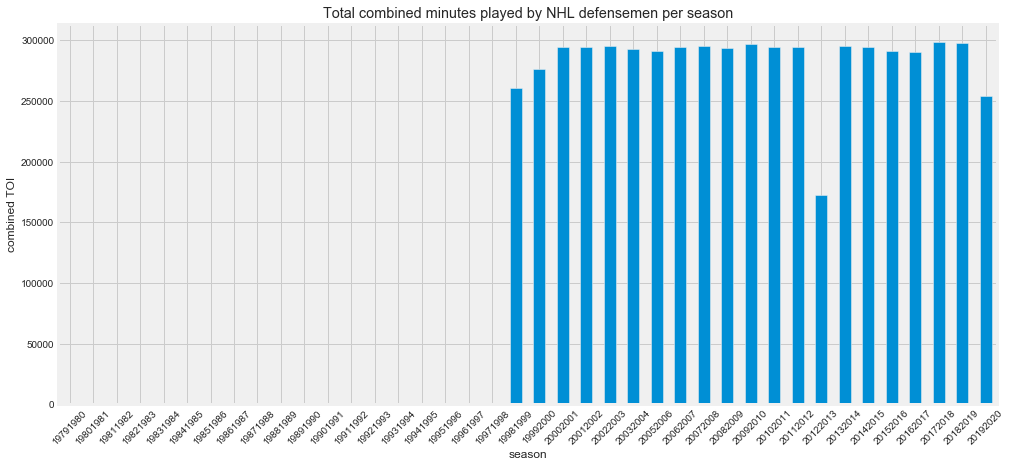

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.style.use('fivethirtyeight')
%matplotlib inline

# create pivot table for total_toi by season
toi_totals = pd.pivot_table(pared_data, index="season", aggfunc=np.sum)["total_toi"]

# create bar plot using pivot table
toi_totals.plot(kind="bar", figsize=(15,7))
plt.xticks(rotation=45)
plt.ylabel("combined TOI")
plt.title("Total combined minutes played by NHL defensemen per season")
plt.show()

We can see that no values exist for `TOI` for seasons prior to 1998-1999.  For now, however, we're going to simply leave these as null values, as we may be interested in testing models both excluding this column altogether *or* using a more limited dataset in order to include it.  There are far too many missing values for an imputation method to be reasonable.

*Note:* The sum value for the 2012-2013 season is noticeably lower than the rest given that it was a truncated season (due to a partial lockout).

#### Blocked Shots & Hits

Let's take a look, as well, at the `blocked_shots` and `hits` columns, each of which only contain about 4000 values out of the 10757 rows.  We can likely expect to see something similar to `TOI`.

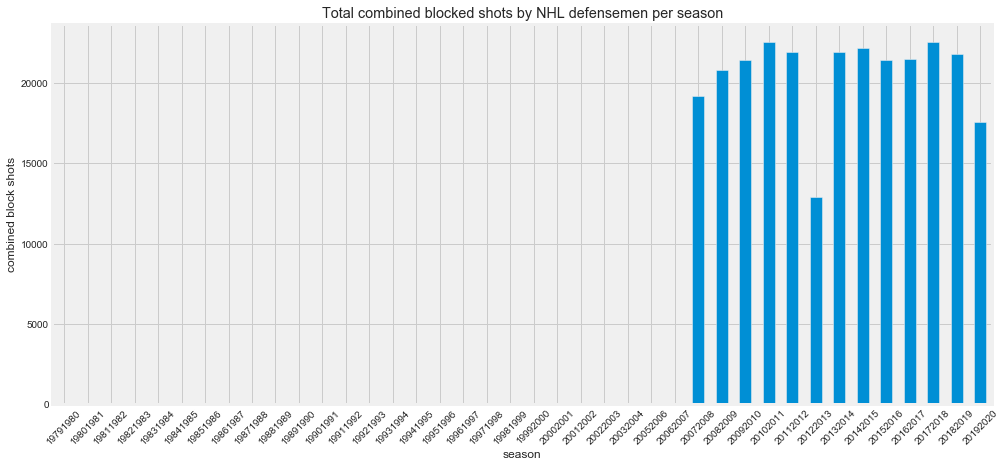

In [42]:
# create pivot table for blocked_shots by season
blocked_shots_totals = pd.pivot_table(pared_data, index="season", aggfunc=np.sum)["blocked_shots"]

# create bar plot using pivot table
blocked_shots_totals.plot(kind="bar", figsize=(15,7))
plt.xticks(rotation=45)
plt.ylabel("combined blocked shots")
plt.title("Total combined blocked shots by NHL defensemen per season")
plt.show()

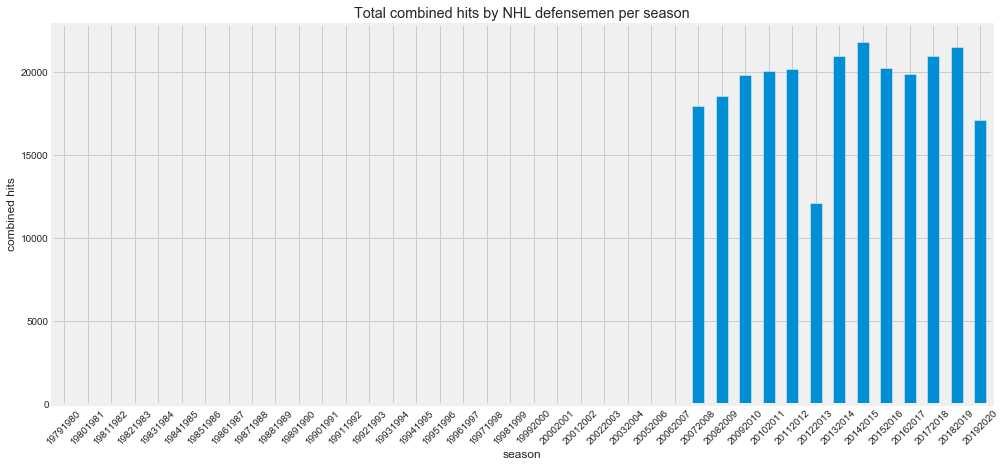

In [43]:
# pivot table for hits by season
hits_totals = pd.pivot_table(pared_data, index="season", aggfunc=np.sum)["hits"]

# create bar plot using pivot table
hits_totals.plot(kind="bar", figsize=(15,7))
plt.xticks(rotation=45)
plt.ylabel("combined hits")
plt.title("Total combined hits by NHL defensemen per season")
plt.show()

It appears that both hits and blocked shots weren't tracked until even more recently (beginning in the 2007-2008 season) and we can attribute the existence null values throughout the prior seasons in our data to this.

Looking closely at our dataframe information, however, we also notice that there are 4 fewer non-null values for blocked shots (3942 non-null) than hits (3946).  This suggests that there may be an additional problem we need to address.

Let's take a look at the entries with values for hits but not blocked shots.

In [44]:
blocked_shots_missing = (pared_data["blocked_shots"].isnull()) & (pared_data["hits"].notnull())
pared_data[blocked_shots_missing]

,name,age,team,games_played,goals,assists,points,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,blocked_shots,hits,season,team_standings_pts,norris_point_pct
7083,Tim Ramholt,23,CGY,1,0,0,0,-1,0,-0.1,0,0,0,0,0,0,0,0,0.0,1.0,1.0,NaN,0.0,20072008,94,0.0
7610,Maxim Noreau,22,MIN,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,7.0,7.0,NaN,0.0,20092010,84,0.0
7645,Rob Davison,29,NJD,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,4.0,4.0,NaN,0.0,20092010,103,0.0
9868,Brian Lashoff,27,DET,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,4.0,4.0,NaN,0.0,20172018,73,0.0


We can see that there are 4, which matches up with the difference we saw above.  It's possible these 4 have null values for `blocked_shots` because they had 0, but let's double check whether there are also entries with an actual value of 0.

In [45]:
len(pared_data[pared_data["blocked_shots"] == 0])

99

We can see that there are entries with an actual value of 0 for `blocked_shots`.

Upon further investigation (including reviewing the original Hockey-Reference.com data tables in the browser), it appears simply that no value was entered for these 4 entries.  In this case, we'll impute the values by treating them as 0s.

In [46]:
# insert 0 for blocked_shots value where missing
pared_data.loc[blocked_shots_missing, "blocked_shots"] = 0

# double check that hits and blocked_shots are left with the same number of null values
pared_data["blocked_shots"].isnull().sum(), pared_data["hits"].isnull().sum()

(6811, 6811)

Similar to our approach with the rest of the null values in the `TOI` column, we're going to allow the rest of the null values in `blocked_shots` and `hits` to remain, given that we may want to try training a model that includes these columns (by using only the data for the seasons where these columns contain non-null values), and there are far too many missing values for further imputation to be reasonable.

### Revisiting Column Info

Now that we've addressed null values to the extent we want, let's take a look at the updated dataframe information.

In [47]:
pared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10757 entries, 0 to 10756
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   10757 non-null  object 
 1   age                    10757 non-null  int64  
 2   team                   10757 non-null  object 
 3   games_played           10757 non-null  int64  
 4   goals                  10757 non-null  int64  
 5   assists                10757 non-null  int64  
 6   points                 10757 non-null  int64  
 7   plus_minus             10757 non-null  int64  
 8   penalty_minutes        10757 non-null  int64  
 9   point_share            10757 non-null  float64
 10  even_strength_goals    10757 non-null  int64  
 11  power_play_goals       10757 non-null  int64  
 12  shorthanded_goals      10757 non-null  int64  
 13  game_winning_goals     10757 non-null  int64  
 14  even_strength_assists  10757 non-null  int64  
 15  po

Reviewing our columns, we see 304 missing values for `norris_point_pct`, which is expected, given the current season (2019-2020) is incomplete, and votes for the award haven't been cast yet (this will be what our model will predict).

The current season, on it's own, should account for the entirety of the null values in that column.

In [48]:
len(pared_data[pared_data["season"] == "20192020"])

304

## Generating Additional Features

Let's move on to creating some additional features that may be useful for our predictive modeling.

#### Per-Game & Per-60 Features

We'll generate some "per-game" and "per-60" values.  These are metrics that are commonly used in the hockey community, primarily as estimators of game-by-game impact/performance.

We'll create both; it's worth including "per-60" (short for "per-60 minute") values, as they are a more standardized metric than per-game values (given they eliminate the impact of both varying game lengths \[i.e. because of overtime\] and differences in minutes played-per-game across players).  They essentially address the question: "For every 60 minutes (the length of a standard, regulation game) a given player would play, what would their production be for X stat?"  As a result, these values are notably different than per-game values.

However, we'll only end up with "per-60" values for the seasons where total time-on-ice was tracked;  for now, we'll apply this to goals, assists, points, hits, and blocked shots (hit and blocked shot values will, of course, only apply to seasons with values for those stats).

In [49]:
stats_to_average = ["goals", "assists", "points", "blocked_shots", "hits"]
pg_suffix = "_per_game"
p60_suffix = "_per_60"

for stat in stats_to_average:
    pg_label = stat + pg_suffix
    pared_data[pg_label] = pared_data[stat] / pared_data["games_played"]
    
    p60_label = stat + p60_suffix
    pared_data[p60_label] = pared_data[stat] / (pared_data["total_toi"] / 60)
    
pared_data.tail()
    

,name,age,team,games_played,goals,assists,points,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,blocked_shots,hits,season,team_standings_pts,norris_point_pct,goals_per_game,goals_per_60,assists_per_game,assists_per_60,points_per_game,points_per_60,blocked_shots_per_game,blocked_shots_per_60,hits_per_game,hits_per_60
10752,Zach Bogosian,29,BUF,27,1,6,7,0,22,1.2,1,0,0,0,5,0,1,29,3.4,449.0,16.629630,27.0,30.0,20192020,68,NaN,0.037037,0.133630,0.222222,0.801782,0.259259,0.935412,1.000000,3.608018,1.111111,4.008909
10753,Zach Trotman,29,PIT,8,0,0,0,-1,4,0.0,0,0,0,0,0,0,0,11,0.0,118.0,14.750000,10.0,21.0,20192020,86,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,5.084746,2.625000,10.677966
10754,Zach Werenski,22,CBJ,63,20,21,41,9,10,9.1,14,5,1,4,13,8,0,187,10.7,1511.0,23.984127,58.0,36.0,20192020,81,NaN,0.317460,0.794176,0.333333,0.833885,0.650794,1.628061,0.920635,2.303111,0.571429,1.429517
10755,Zach Whitecloud,23,VEG,16,0,1,1,3,4,0.5,0,0,0,0,1,0,0,9,0.0,229.0,14.312500,16.0,10.0,20192020,86,NaN,0.000000,0.000000,0.062500,0.262009,0.062500,0.262009,1.000000,4.192140,0.625000,2.620087
10756,Zdeno Chara,42,BOS,68,5,9,14,26,60,5.1,5,0,0,2,9,0,0,86,5.8,1429.0,21.014706,101.0,78.0,20192020,100,NaN,0.073529,0.209937,0.132353,0.377887,0.205882,0.587824,1.485294,4.240728,1.147059,3.275017


In [50]:
pared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10757 entries, 0 to 10756
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    10757 non-null  object 
 1   age                     10757 non-null  int64  
 2   team                    10757 non-null  object 
 3   games_played            10757 non-null  int64  
 4   goals                   10757 non-null  int64  
 5   assists                 10757 non-null  int64  
 6   points                  10757 non-null  int64  
 7   plus_minus              10757 non-null  int64  
 8   penalty_minutes         10757 non-null  int64  
 9   point_share             10757 non-null  float64
 10  even_strength_goals     10757 non-null  int64  
 11  power_play_goals        10757 non-null  int64  
 12  shorthanded_goals       10757 non-null  int64  
 13  game_winning_goals      10757 non-null  int64  
 14  even_strength_assists   10757 non-null

Let's export a CSV of our dataset in its current state to be made available for use beyond this project.

In [51]:
pared_data.to_csv("norris_data_full.csv")

## Rescaling Continuous Variables

Next, we're going to normalize our continuous variable columns.  Given that the Norris Trophy is a "best of" award, we're interested in a given player's performance *relative to their peers* each season, rather than the exact numbers they produced.  For each variable, we're interested in where an individual falls within a league-wide distribution __per season__.

In addition, we're interested in establishing a certain level of equivalency across seasons; where total values and distributions may differ season-to-season (for various reasons including shorter seasons, higher/lower overall scoring rates, rule changes, etc).

We'll create and use a rescaling function, and this step is where we'll also separate the data for all previous seaons from the data for the current season (which, again, contains no voting data and is the season we'll make predictions for).

In [52]:
from sklearn.preprocessing import minmax_scale

# create function to rescale continuous variables season-by-season
def rescale_continuous(df, cols):
    for season in df["season"].unique():
        season_cols = df.loc[df["season"] == season, cols].copy()
        rescaled_data = minmax_scale(season_cols)
        df.loc[df["season"] == season, cols] = rescaled_data

# segment our data into 1) past seasons and 2) the current season
past_seasons_data = pared_data[pared_data["season"] != "20192020"].copy()
current_season_data = pared_data[pared_data["season"] == "20192020"].copy()

# create list of columns to apply our rescaling to
rescale_columns = ["age", "games_played", "goals", "assists", "points", "plus_minus", "penalty_minutes", "point_share", "even_strength_goals", "power_play_goals", "shorthanded_goals", "game_winning_goals", "even_strength_assists", "power_play_assists", "shorthanded_assists", "shots", "shooting_pct", "total_toi", "avg_toi", "blocked_shots", "hits", "team_standings_pts", "goals_per_game", "goals_per_60", "assists_per_game", "assists_per_60", "points_per_game", "points_per_60", "blocked_shots_per_game", "blocked_shots_per_60", "hits_per_game", "hits_per_60"]

# apply rescaling to both
rescale_continuous(past_seasons_data, rescale_columns)
rescale_continuous(current_season_data, rescale_columns)

In [53]:
# take a look at a sample of the data to check whether our continuous variables have been properly rescaled
past_seasons_data.tail(10)

,name,age,team,games_played,goals,assists,points,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,blocked_shots,hits,season,team_standings_pts,norris_point_pct,goals_per_game,goals_per_60,assists_per_game,assists_per_60,points_per_game,points_per_60,blocked_shots_per_game,blocked_shots_per_60,hits_per_game,hits_per_60
10443,Victor Mete,0.086957,MTL,0.843373,0.00,0.194030,0.156627,0.7250,0.052174,0.305344,0.000000,0.000000,0.00,0.000000,0.309524,0.00000,0.0,0.216667,0.000,0.574966,0.547072,0.456731,0.081395,20182019,0.500000,0.000000,0.000000,0.000000,0.183099,0.154517,0.180893,0.144216,0.451383,0.376387,0.049296,0.036054
10444,Vince Dunn,0.173913,STL,0.927711,0.60,0.343284,0.421687,0.6875,0.391304,0.587786,0.529412,0.428571,0.00,0.666667,0.428571,0.15625,0.0,0.500000,0.080,0.623567,0.535080,0.326923,0.186047,20182019,0.546875,0.000000,0.307692,0.184211,0.294872,0.252193,0.443312,0.358187,0.294099,0.248538,0.102564,0.076023
10445,Will Butcher,0.260870,NJD,0.927711,0.20,0.388060,0.361446,0.3000,0.156522,0.351145,0.176471,0.142857,0.00,0.166667,0.309524,0.40625,0.0,0.360000,0.037,0.685465,0.622958,0.355769,0.147287,20182019,0.125000,0.000000,0.102564,0.055888,0.333333,0.259481,0.379981,0.279441,0.320049,0.246174,0.081197,0.054779
10446,William Borgen,0.173913,BUF,0.036145,0.00,0.000000,0.000000,0.4500,0.000000,0.015267,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.0,0.006667,0.000,0.026593,0.482353,0.014423,0.046512,20182019,0.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.253012,0.227273,0.500000,0.393939
10447,Xavier Ouellet,0.304348,MTL,0.216867,0.00,0.044776,0.036145,0.4750,0.113043,0.061069,0.000000,0.000000,0.00,0.000000,0.071429,0.00000,0.0,0.106667,0.000,0.144429,0.507740,0.144231,0.124031,20182019,0.500000,0.000000,0.000000,0.000000,0.157895,0.139319,0.155992,0.130031,0.532657,0.464396,0.280702,0.214654
10448,Yannick Weber,0.521739,NSH,0.734940,0.10,0.089552,0.096386,0.6000,0.156522,0.213740,0.117647,0.000000,0.00,0.000000,0.142857,0.00000,0.0,0.223333,0.030,0.335167,0.249775,0.153846,0.248062,20182019,0.562500,0.000000,0.064516,0.056834,0.096774,0.121786,0.127478,0.151556,0.174116,0.216509,0.172043,0.187641
10449,Zach Bogosian,0.434783,BUF,0.771084,0.15,0.238806,0.228916,0.4500,0.452174,0.320611,0.117647,0.000000,0.25,0.000000,0.357143,0.03125,0.0,0.310000,0.032,0.640990,0.742863,0.557692,0.321705,20182019,0.187500,0.000000,0.092308,0.044808,0.246154,0.170697,0.288786,0.189189,0.602039,0.412518,0.212821,0.127904
10450,Zach Trotman,0.434783,PIT,0.144578,0.00,0.014925,0.012048,0.5625,0.034783,0.076336,0.000000,0.000000,0.00,0.000000,0.000000,0.03125,0.0,0.053333,0.000,0.087116,0.417909,0.086538,0.077519,20182019,0.562500,0.000000,0.000000,0.000000,0.076923,0.075758,0.075996,0.070707,0.467099,0.454545,0.256410,0.218855
10451,Zach Werenski,0.130435,CBJ,0.975904,0.55,0.492537,0.530120,0.3625,0.156522,0.534351,0.529412,0.285714,0.00,0.166667,0.476190,0.40625,0.0,0.560000,0.065,0.857405,0.807430,0.427885,0.259690,20182019,0.531250,0.000000,0.268293,0.123003,0.402439,0.263578,0.530120,0.328009,0.366148,0.236954,0.136179,0.077299
10452,Zdeno Chara,1.000000,BOS,0.734940,0.25,0.134328,0.168675,0.7875,0.495652,0.404580,0.235294,0.142857,0.00,0.333333,0.166667,0.06250,0.0,0.330000,0.051,0.595598,0.714931,0.423077,0.313953,20182019,0.671875,0.000675,0.161290,0.080337,0.145161,0.103290,0.223086,0.149962,0.478818,0.336649,0.217742,0.134277


## Addressing Redundancy/Colinearity

We're going to be using recursive feature elimination (RFE) as our method for feature selection for a linear model (we'll be using a basic linear regression algorithm first), so we'll want to make sure to eliminate redundant columns or those with a high level of colinearity.

We can take a look at a heatmap (generated based on a correlation matrix of our dataset) to help us evaluate which features we may want to eliminate.

We'll want to keep in mind that, when it comes to apparent correlations; the more total ice-time a player had in a season, the greater multiple values are likely to be for them.

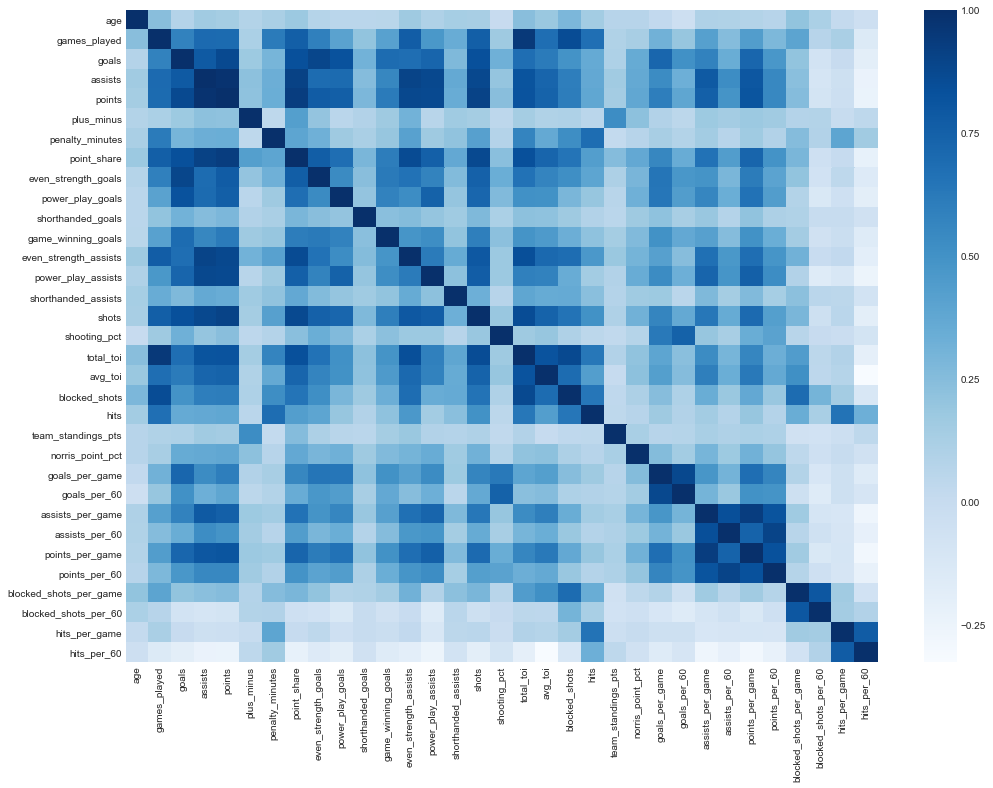

In [54]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(past_seasons_data.corr(), ax=ax, cmap="Blues")
plt.show()

From reviewing our heatmap and considering our features, we'll make a couple of initial elimination choices, focusing on the individual points/"points per-" metrics:
- `points`: Highly correlated with goals and assists (unsurprising, as it is simply a sum of the two and doesn't provide any additional information), as well as `point_share`
- `points_per_game` & `points_per_60`: Similar to `points`; highly correlated with goals/assists per game/60, and doesn't provide any additional information

In [55]:
past_seasons_filtered = past_seasons_data.drop(["points", "points_per_game", "points_per_60"], axis = 1)
current_season_filtered = current_season_data.drop(["points", "points_per_game", "points_per_60"], axis = 1)

We do see some high levels of correlation among a couple of other variables, but these will be addressed once we drop incomplete columns, regardless.

## Encoding Categorical Variables

For now, our only categorical column is `team`.  We have options for handling this column, but we'll elect to employ one hot encoding here, using pandas to create individual (dummy) columns representative of each team.

In [56]:
# generate dummy columns based on the team column
team_columns = pd.get_dummies(pared_data["team"], prefix="team")

# join dummy columns to existing dataframes and remove the original team column
past_seasons_filtered = past_seasons_filtered.join(team_columns).drop("team", axis = 1)
current_season_filtered = current_season_filtered.join(team_columns).drop("team", axis = 1)

# let's take a look at a sample of our data to ensure this was properly executed
past_seasons_filtered.head()

,name,age,games_played,goals,assists,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,blocked_shots,hits,season,team_standings_pts,norris_point_pct,goals_per_game,goals_per_60,assists_per_game,assists_per_60,blocked_shots_per_game,blocked_shots_per_60,hits_per_game,hits_per_60,team_ANA,team_ARI,team_ATF,team_ATL,team_BOS,team_BUF,team_CAR,team_CBJ,team_CGY,team_CHI,team_CLR,team_COL,team_DAL,team_DET,team_EDM,team_FLA,team_HAR,team_LAK,team_MIN,team_MNS,team_MTL,team_NJD,team_NSH,team_NYI,team_NYR,team_OTT,team_PHI,team_PIT,team_QUE,team_SJS,team_STL,team_TBL,team_TOR,team_VAN,team_VEG,team_WIN,team_WPG,team_WSH
0,Al Cameron,0.227273,0.784810,0.125000,0.180328,0.163462,0.339623,0.254098,0.176471,0.000,0.0,0.0,0.20,0.107143,0.000000,0.279863,0.196809,NaN,NaN,NaN,NaN,19791980,0.000000,0.0,0.146825,NaN,0.164021,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Al Hamilton,0.636364,0.379747,0.166667,0.245902,0.413462,0.094340,0.229508,0.176471,0.125,0.0,0.0,0.20,0.214286,0.333333,0.116041,0.627660,NaN,NaN,NaN,NaN,19791980,0.276923,0.0,0.397849,NaN,0.454545,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Al Hangsleben,0.318182,0.924051,0.541667,0.360656,0.519231,0.537736,0.549180,0.647059,0.250,0.0,0.4,0.15,0.035714,0.000000,0.365188,0.643617,NaN,NaN,NaN,NaN,19791980,0.338462,0.0,0.541667,NaN,0.279279,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Al Sims,0.318182,0.949367,0.416667,0.508197,0.519231,0.141509,0.508197,0.470588,0.250,0.0,0.2,0.60,0.214286,0.333333,0.481229,0.377660,NaN,NaN,NaN,NaN,19791980,0.338462,0.0,0.405702,NaN,0.383174,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Andre Dore,0.090909,0.012658,0.000000,0.000000,0.413462,0.000000,0.032787,0.000000,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,19791980,0.538462,0.0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Dropping Incomplete Columns

Since we're going to start out by training a linear regression model using our full 40-year dataset, we'll filter out any columns with null values.  We can come back and try training on just the seasons that include these additional variables later.

This will, as a result, filter out the remaining "per-60" variables, which also presented some colinearity concerns.

In [57]:
full_past_filtered = past_seasons_filtered.dropna(axis=1)
full_past_filtered.head()

,name,age,games_played,goals,assists,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,season,team_standings_pts,norris_point_pct,goals_per_game,assists_per_game,team_ANA,team_ARI,team_ATF,team_ATL,team_BOS,team_BUF,team_CAR,team_CBJ,team_CGY,team_CHI,team_CLR,team_COL,team_DAL,team_DET,team_EDM,team_FLA,team_HAR,team_LAK,team_MIN,team_MNS,team_MTL,team_NJD,team_NSH,team_NYI,team_NYR,team_OTT,team_PHI,team_PIT,team_QUE,team_SJS,team_STL,team_TBL,team_TOR,team_VAN,team_VEG,team_WIN,team_WPG,team_WSH
0,Al Cameron,0.227273,0.784810,0.125000,0.180328,0.163462,0.339623,0.254098,0.176471,0.000,0.0,0.0,0.20,0.107143,0.000000,0.279863,0.196809,19791980,0.000000,0.0,0.146825,0.164021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Al Hamilton,0.636364,0.379747,0.166667,0.245902,0.413462,0.094340,0.229508,0.176471,0.125,0.0,0.0,0.20,0.214286,0.333333,0.116041,0.627660,19791980,0.276923,0.0,0.397849,0.454545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Al Hangsleben,0.318182,0.924051,0.541667,0.360656,0.519231,0.537736,0.549180,0.647059,0.250,0.0,0.4,0.15,0.035714,0.000000,0.365188,0.643617,19791980,0.338462,0.0,0.541667,0.279279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Al Sims,0.318182,0.949367,0.416667,0.508197,0.519231,0.141509,0.508197,0.470588,0.250,0.0,0.2,0.60,0.214286,0.333333,0.481229,0.377660,19791980,0.338462,0.0,0.405702,0.383174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Andre Dore,0.090909,0.012658,0.000000,0.000000,0.413462,0.000000,0.032787,0.000000,0.000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,19791980,0.538462,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Selecting Features With RFE

Now we'll use recursive feature elimination to determine the highest performing set of features for a linear regression model.  
Before doing so, we'll drop the `name` column, as it serves no purpose for model training; and the `season` column, as it is simply a means to label/separate subsets of our data (but we don't want it involved in our actual model training process - we want all seasons, combined, treated as one complete dataset).

In [58]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# filter to feature columns for past_X, target column for past_y
past_X = full_past_filtered.drop(["norris_point_pct", "name", "season"], axis = 1)
past_y = full_past_filtered["norris_point_pct"]

# KFold for cross-validation; random_state set for reproduceability
kf = KFold(n_splits=10, random_state = 5)

# check feature columns
print(past_X.columns)

# fit RFECV, using linear regression, with the data
lr_model = LinearRegression()
selector = RFECV(lr_model, cv = kf)
selector.fit(past_X, past_y)

Index(['age', 'games_played', 'goals', 'assists', 'plus_minus',
       'penalty_minutes', 'point_share', 'even_strength_goals',
       'power_play_goals', 'shorthanded_goals', 'game_winning_goals',
       'even_strength_assists', 'power_play_assists', 'shorthanded_assists',
       'shots', 'shooting_pct', 'team_standings_pts', 'goals_per_game',
       'assists_per_game', 'team_ANA', 'team_ARI', 'team_ATF', 'team_ATL',
       'team_BOS', 'team_BUF', 'team_CAR', 'team_CBJ', 'team_CGY', 'team_CHI',
       'team_CLR', 'team_COL', 'team_DAL', 'team_DET', 'team_EDM', 'team_FLA',
       'team_HAR', 'team_LAK', 'team_MIN', 'team_MNS', 'team_MTL', 'team_NJD',
       'team_NSH', 'team_NYI', 'team_NYR', 'team_OTT', 'team_PHI', 'team_PIT',
       'team_QUE', 'team_SJS', 'team_STL', 'team_TBL', 'team_TOR', 'team_VAN',
       'team_VEG', 'team_WIN', 'team_WPG', 'team_WSH'],
      dtype='object')


RFECV(cv=KFold(n_splits=10, random_state=5, shuffle=False),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

Let's see which columns the selector settled on as the highest performing for a default-paremeters instance of LinearRegression.

In [59]:
optimized_columns = past_X.columns[selector.support_]
optimized_columns

Index(['team_ANA', 'team_ARI', 'team_ATL', 'team_BOS', 'team_BUF', 'team_CAR',
       'team_CBJ', 'team_CGY', 'team_CHI', 'team_CLR', 'team_COL', 'team_DAL',
       'team_DET', 'team_EDM', 'team_FLA', 'team_HAR', 'team_LAK', 'team_MIN',
       'team_MNS', 'team_MTL', 'team_NJD', 'team_NSH', 'team_NYI', 'team_NYR',
       'team_OTT', 'team_PHI', 'team_PIT', 'team_QUE', 'team_SJS', 'team_STL',
       'team_TBL', 'team_TOR', 'team_VAN', 'team_WIN', 'team_WPG', 'team_WSH'],
      dtype='object')

Interestingly, the `RFECV` selector settled on a set of only team dummy columns as the highest performing combination of features.  This may indicate that linear regression (or linear algorithms as a whole) may simply be the wrong fit given our data as it is, and will perform very poorly; but let's follow through with our workflow, anyway, and find out.

## Partitioning the Data & Validating Linear Regression

Now we'll filter our data to the features selected by RFE and then separate our data into training and testing (holdout) sets.  We'll then perform cross-validation on the training set using a linear regression model, compute the average root mean squared error (which we're going to use as our metric for determining model performance in this project), and compare it to the RMSE value achieved by using that model to make predictions on the test set.

This will allow us to get a sense as to both the overall model performance and whether the model might be overfitting.

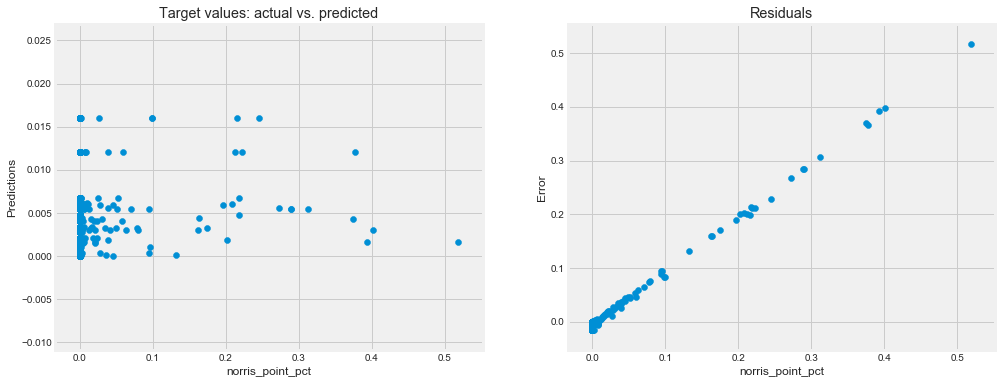

(0.02938582257921763, 0.02928892867550068)

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def validate_test(model, X_train, X_test, y_train, y_test):
    """Runs 10-fold cross-validation on a training set-trained model; computes average RMSE; then computes test set RMSE for comparison (checking for overfitting, etc)."""
    kf = KFold(n_splits = 10, random_state = 1)
    
    # calculate neg MSE values for cross-validation
    cv_neg_mse_scores = list(cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
    
    # convert to RMSE values
    cv_rmse_scores = [np.sqrt(-mse) for mse in cv_neg_mse_scores]
    
    # calculate RMSE average for CV
    val_rmse_avg = np.average(cv_rmse_scores)
    
    # fit model, generate predictions, and compute RMSE value for test set to compare
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    # prediction accuracy and residuals plots for test data
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    ax1.scatter(x = y_test, y = predictions)
    ax1.set_xlabel("norris_point_pct")
    ax1.set_ylabel("Predictions")
    ax1.set_title("Target values: actual vs. predicted")
    ax2.scatter(x = y_test, y = y_test - predictions)
    ax2.set_xlabel("norris_point_pct")
    ax2.set_ylabel("Error")
    ax2.set_title("Residuals")
    plt.show()
    
    # return both resulting RMSE values for comparison
    return (val_rmse_avg, test_rmse)

# filter past_X dataframe to features selected by RFE
past_X_opt = past_X[optimized_columns].copy()

# split feature-selected dataset to train and test feature/target segments
X_train, X_test, y_train, y_test = train_test_split(past_X_opt, past_y, test_size = 0.2, random_state = 1)

# train linear regression model and produce RMSE values
lr_model = LinearRegression()
validate_test(lr_model, X_train, X_test, y_train, y_test)

Interestingly, not only are the RMSE values from cross-validation and making predictions on the holdout set similar, but they are also quite low.  This looks good on its own, but may be heavily skewed by the fact that the vast majority of entries had a `norris_point_pct` value of 0 (and a predicted value close to 0), which is suggested by the first plot above.

The second plot, our residuals plot, shows a linear relationship between actual `norris_point_pct` value and error; which not only suggests extremely poor performance by the model, but is also unsurprising given that, as we can see in the first plot, predicted target values only range between 0 and roughly 0.16 (while the actual `norris_point_pct` values range between 0 and over 0.5).

Let's take a look at a comparison of 0 vs. non-zero `norris_point_pct` values in our entire historical dataset to get a better idea as to why our RMSE values may appear good despite very poor model performance.

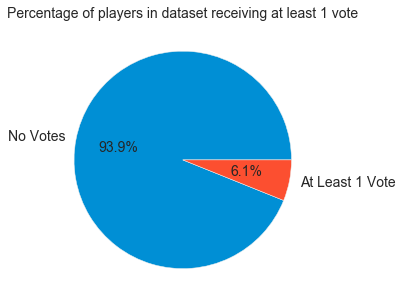

In [61]:
# calculate percentage of 0 vote-getters vs non-0 vote-getters
votes_zero = past_y[past_y == 0.0].count()
votes_above_zero = past_y[past_y > 0.0].count()
vote_count_percentages = [votes_zero, votes_above_zero]

# create pie plot
plt.figure(figsize=(5,5))
plt.pie(vote_count_percentages, labels=["No Votes", "At Least 1 Vote"], autopct='%1.1f%%', textprops = {"fontsize": 14})
plt.title("Percentage of players in dataset receiving at least 1 vote", fontsize = 14)
plt.show()

Only about 6.1% of the entire historical dataset we're working with have `norris_point_pct` values greater than 0 (unsurprising given that votes are only given to the top performers in the league each season).

Just for some further insight into performance, let's also take a closer look at the entries in our test set that had the *highest* original `norris_point_pct` values and see what predictions are made by a linear regression model.

In [62]:
# use linear regression model to make predictions on test data and filter error values to just 1+ vote getters
test_pred = lr_model.predict(X_test)
test_data = X_test.copy()
test_data["prediction_pct"] = test_pred
test_data["norris_point_pct"] = y_test
test_data["error"] = test_data["norris_point_pct"] - test_data["prediction_pct"]

test_data[test_data["norris_point_pct"] > 0][["norris_point_pct", "prediction_pct", "error"]].sort_values(by="norris_point_pct", ascending=False).head(10)

,norris_point_pct,prediction_pct,error
1396,0.518519,0.001605,0.516913
3304,0.401235,0.003015,0.398219
1177,0.393298,0.001605,0.391693
7021,0.377407,0.012019,0.365388
4736,0.374668,0.004283,0.370386
459,0.312169,0.005417,0.306752
8700,0.290006,0.005417,0.284589
3376,0.288889,0.005417,0.283472
8275,0.272845,0.005623,0.267222
781,0.245150,0.015972,0.229178


We can see that a linear regression model's predicted values come nowhere close to the original values for our target column.  As a matter of fact, while test data target column values range anywhere from 0 to 0.518, predicted values fall within an extremely limited range, as seen above in the scatter plots.

Altogether, these outcomes support the suggestion, brought up by RFE's selection of nothing but team dummy columns as the "highest performing subset of features," that a linear model used with our data isn't a good fit for this task.

## Testing Other (Tree-Based) Algorithms

Given linear regression's very poor initial testing performance, let's try a couple of other algorithms with the same set of data.  Our goal, for now, is not to run through an exhaustive list; but rather to to at least find an alternative with significantly better predictive performance compared to our linear regression model.

We'll return to our `past_X` and `past_y` dataframes, and try a couple of tree-based algorithms; in particular: `DecisionTreeRegressor`, `RandomForestRegressor` and `GradientBoostingRegressor` from scikit-learn.

For now, we'll test them with default hyperparameter values (and, again, compare average RMSE from cross-validation on the training data with RMSE from generating predictions on the holdout data).

Since we're now working with tree-based models, we'll use scikit-learn's `LabelEncoder` to apply integer encoding to our `team` column; as opposed to the one-hot encoding approach we used earlier.

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import LabelEncoder

# pre-process data for use with tree-based models
past_X = past_seasons_data.drop(["name", "season", "norris_point_pct"], axis = 1).copy()
past_y = past_seasons_data["norris_point_pct"].copy()

# create reusable preprocessing function
def tree_preprocess(X, y):
    # drop columns with null values from X
    X = X.dropna(axis = 1)
    
    # re-partition the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

    # integer encode team column for train and test sets
    lenc = LabelEncoder()
    lenc.fit(X_train["team"])
    X_train["team"] = lenc.transform(X_train["team"])
    X_test["team"] = lenc.transform(X_test["team"])
    
    return X_train, X_test, y_train, y_test

# preprocess and split
X_train_full_past, X_test_full_past, y_train_full_past, y_test_full_past = tree_preprocess(past_X, past_y)

# instantiate models with default hyperparameter values and a random seed set
dt_model = DecisionTreeRegressor(random_state = 1)
rf_model = RandomForestRegressor(random_state = 1)
gb_model = GradientBoostingRegressor(random_state = 1)

In [64]:
# double-check that train and test sets comprise same columns after dropping nulls
list(X_train_full_past.columns) == list(X_test_full_past.columns)

True

#### Decision Tree

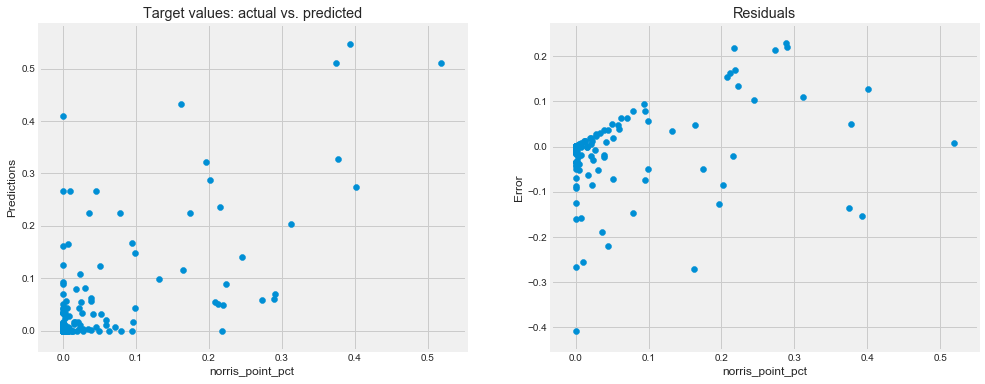

(0.025240742872899975, 0.022624248324668673)

In [65]:
validate_test(dt_model, X_train_full_past, X_test_full_past, y_train, y_test)

Already, we see improvement in overall predictive performance compared to our linear regression model; though some notable outliers exist.

#### Random Forest

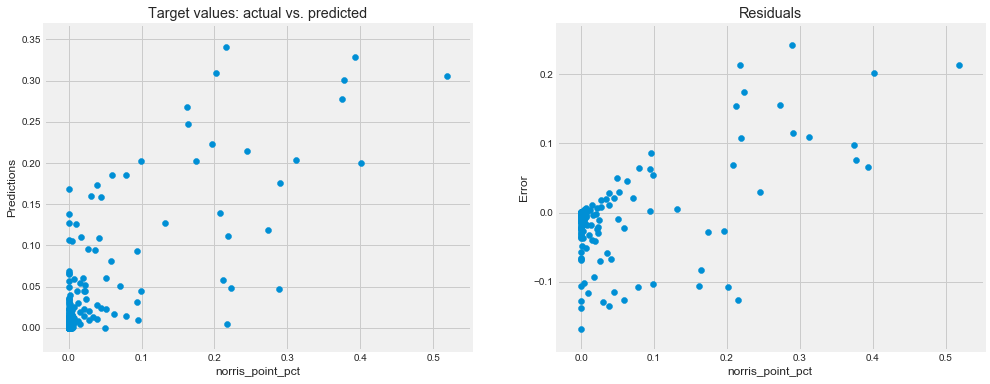

(0.017969577543589115, 0.017698511108403057)

In [66]:
validate_test(rf_model, X_train_full_past, X_test_full_past, y_train, y_test)

We can see improvements in the RMSE values for both cross-validation average and holdout set predictions.  We can still see a bit of a pattern in the residuals, however; but there are improvements in overall predictive performance, nonetheless.

#### Gradient Boost

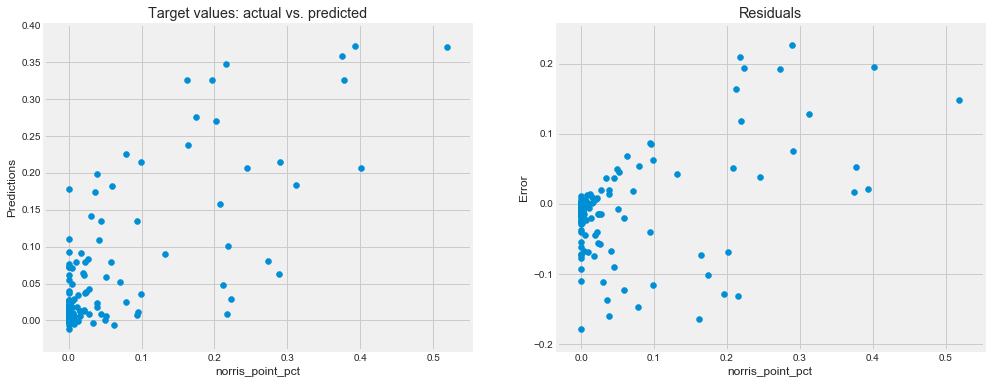

(0.0180387072260575, 0.017753826475261518)

In [67]:
validate_test(gb_model, X_train_full_past, X_test_full_past, y_train, y_test)

Performance here is worse than the random forest, but only *very* slightly.

Overall, we're off to a good start, but let's move on to incorporating more features in training these models and see if we can achieve additional performance gains.

## Testing Tree-Based Models, Incorporating Time-on-Ice/Average Time-on-Ice

Given the presence of null values due to a lack of tracking of these metrics in years leading up to the 1998-1999 season, we omitted them from our model training in order to incorporate all seasons.  Let's now take a different approach, and limit our data to only the seasons with non-null values for the `TOI` & `ATOI` columns.  Time-on-ice can often be used as a proxy for a player's impact & value to his team, so it's possible it may have a noticeable effect on model performance.

We'll accomplish filtering our data this way by returning to our base `past_X` and `past_y`, dropping all rows prior to the `19981999` season (that season begins with row index 4388), and pre-processing again..

In [68]:
# filter data to only seasons 19981999 and later (index 4388+)
past_X_toi = past_X.loc[4388:].copy()
past_y_toi = past_y.loc[4388:].copy()

# re-split and preprocess
X_train_toi, X_test_toi, y_train_toi, y_test_toi = tree_preprocess(past_X_toi, past_y_toi)

X_train_toi.head()

,age,team,games_played,goals,assists,points,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,team_standings_pts,goals_per_game,goals_per_60,assists_per_game,assists_per_60,points_per_game,points_per_60
9753,0.428571,18,0.802469,0.344828,0.535714,0.526316,0.382353,0.285714,0.414013,0.333333,0.250000,0.0,0.333333,0.470588,0.448276,0.333333,0.443750,0.21021,0.723222,0.870324,0.657143,0.428422,0.235878,0.641234,0.297952,0.653907,0.397269
9248,0.428571,12,0.074074,0.000000,0.000000,0.000000,0.396226,0.016807,0.037313,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.033994,0.00000,0.041281,0.470002,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5621,0.227273,16,0.951220,0.722222,0.461538,0.544118,0.608696,0.173469,0.637681,0.909091,0.214286,0.0,0.285714,0.480000,0.428571,0.000000,0.531773,0.08200,0.764461,0.770312,0.307692,0.493671,0.148370,0.467381,0.339130,0.551005,0.422283
9999,0.428571,1,0.777778,0.058824,0.101695,0.102941,0.394737,0.312500,0.174603,0.066667,0.000000,0.0,0.200000,0.162162,0.000000,0.000000,0.177711,0.01700,0.475649,0.542462,0.145455,0.015625,0.010486,0.046875,0.045758,0.054688,0.053384
4998,0.318182,15,0.839506,0.142857,0.068966,0.088608,0.281690,0.642157,0.227941,0.090909,0.181818,0.0,0.000000,0.148148,0.000000,0.000000,0.235294,0.09400,0.369122,0.376154,0.242424,0.130435,0.067340,0.075808,0.127946,0.105302,0.157127


In [69]:
# re-instantiate tree-based models with default hyperparameter values and random_state set
dt_model = DecisionTreeRegressor(random_state = 1)
rf_model = RandomForestRegressor(random_state = 1)
gb_model = GradientBoostingRegressor(random_state = 1)

#### Decision Tree

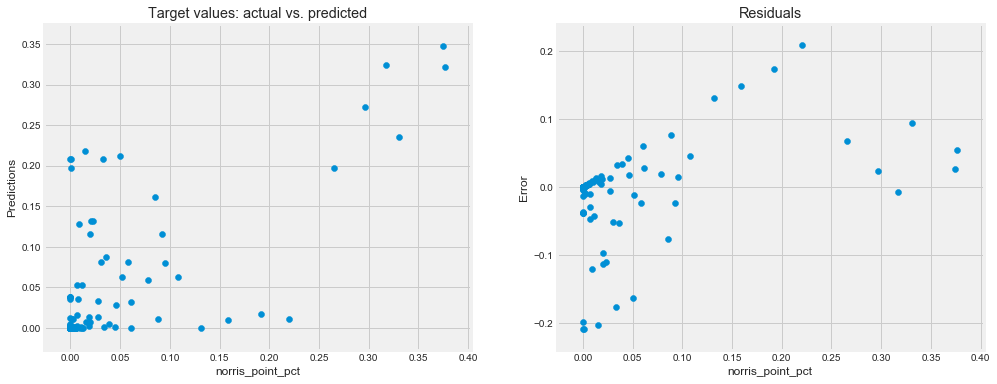

(0.021129324237452146, 0.019154447062973392)

In [70]:
validate_test(dt_model, X_train_toi, X_test_toi, y_train_toi, y_test_toi)

#### Random Forest

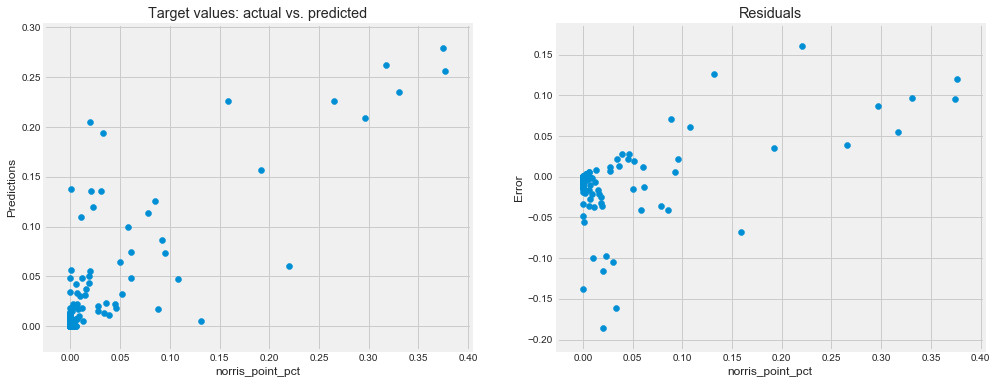

(0.014340580317813984, 0.014373824543819422)

In [71]:
validate_test(rf_model, X_train_toi, X_test_toi, y_train_toi, y_test_toi)

#### Gradient Boost

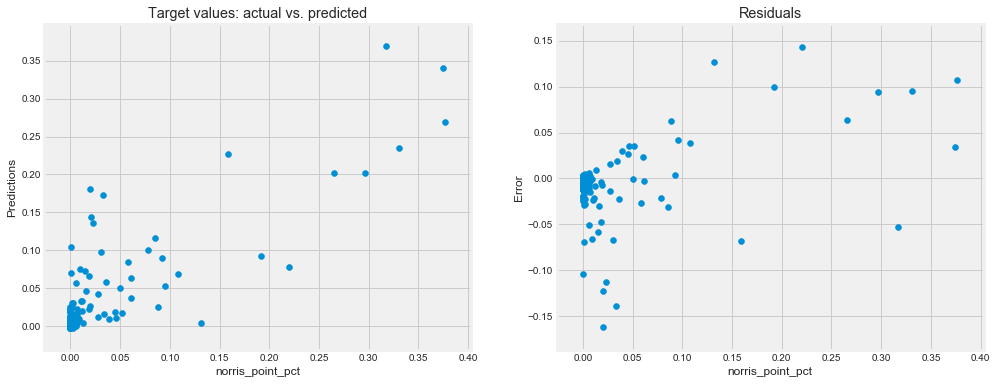

(0.014449137005823115, 0.013452859897205481)

In [72]:
validate_test(gb_model, X_train_toi, X_test_toi, y_train_toi, y_test_toi)

Overall model performance appears improved across all 3 algorithms, with the `GradientBoostingRegressor` model appearing to perform the best on the test set and manage outliers the most, this time.

Finally, let's look at incorporating `hits` and `blocked_shots` and see if we can achieve even better performance from our tree-based models.

## Testing Tree-Based Models, Incorporating Hits & Blocked Shots

Hits and blocked shots weren't tracked until the `20072008` season (the data for which starts at index 6811 in our dataset, as seen below) giving us only 12 seasons of historical data to train our models with (leading our holdout dataset, in particular, to be very small); but let's test it, anyway.

In [73]:
past_X[past_X["hits"].notnull()].head()

,age,team,games_played,goals,assists,points,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,blocked_shots,hits,team_standings_pts,goals_per_game,goals_per_60,assists_per_game,assists_per_60,points_per_game,points_per_60,blocked_shots_per_game,blocked_shots_per_60,hits_per_game,hits_per_60
6811,0.185185,NYI,0.353659,0.000000,0.033333,0.028571,0.449275,0.164835,0.105960,0.000000,0.0,0.0,0.00,0.033333,0.026316,0.00,0.060837,0.000,0.184363,0.486206,0.123348,0.154135,0.181818,0.000000,0.000000,0.066667,0.062500,0.066667,0.062500,0.299203,0.302885,0.341667,0.197115
6812,0.629630,VAN,0.682927,0.052632,0.133333,0.128571,0.405797,0.175824,0.192053,0.083333,0.0,0.0,0.25,0.266667,0.000000,0.00,0.102662,0.185,0.438472,0.617204,0.352423,0.139098,0.386364,0.061865,0.060782,0.140351,0.105263,0.157895,0.118421,0.449929,0.364372,0.162281,0.074899
6813,0.185185,CBJ,0.195122,0.052632,0.016667,0.028571,0.362319,0.181319,0.072848,0.083333,0.0,0.0,0.00,0.033333,0.000000,0.00,0.057034,0.335,0.136828,0.649065,0.074890,0.124060,0.204545,0.207430,0.194345,0.058824,0.042071,0.117647,0.084142,0.320574,0.247573,0.485294,0.213592
6814,0.592593,BOS,0.780488,0.263158,0.133333,0.185714,0.550725,0.296703,0.311258,0.416667,0.0,0.0,0.75,0.166667,0.078947,0.00,0.258555,0.370,0.598401,0.745877,0.515419,0.530075,0.522727,0.271255,0.222747,0.123077,0.077151,0.200000,0.125371,0.577033,0.390579,0.542308,0.209199
6815,0.629630,CBJ,0.902439,0.052632,0.250000,0.228571,0.449275,0.587912,0.331126,0.000000,0.0,0.5,0.00,0.400000,0.052632,0.25,0.250951,0.075,0.778765,0.845948,0.651982,0.349624,0.204545,0.047018,0.034238,0.200000,0.111174,0.213333,0.118586,0.632600,0.379704,0.310000,0.106043


In [74]:
# filter data to only seasons 20072008 and later (index 6811+)
past_X_all_stats = past_X.loc[6811:].copy()
past_y_all_stats = past_y.loc[6811:].copy()

# re-split and preprocess
X_train_all_stats, X_test_all_stats, y_train_all_stats, y_test_all_stats = tree_preprocess(past_X_all_stats, past_y_all_stats)

dt_model = DecisionTreeRegressor(random_state = 1)
rf_model = RandomForestRegressor(random_state = 1)
gb_model = GradientBoostingRegressor(random_state = 1)

#### Decision Tree

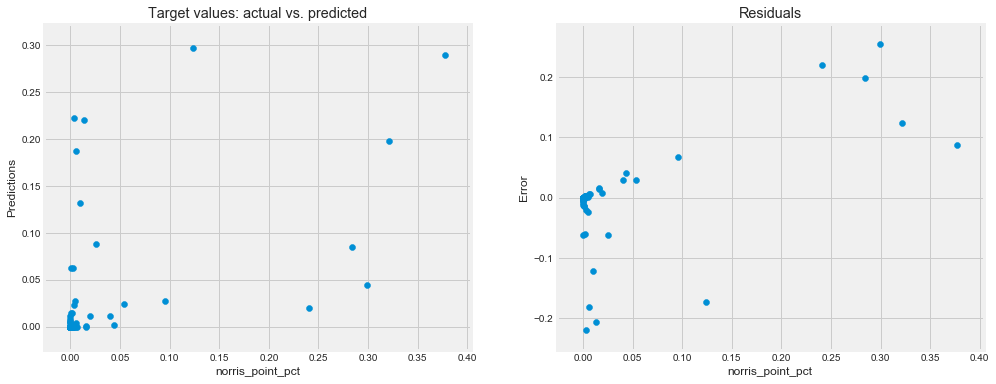

(0.023006528316851578, 0.022412863172636688)

In [75]:
validate_test(dt_model, X_train_all_stats, X_test_all_stats, y_train_all_stats, y_test_all_stats)

#### Random Forest

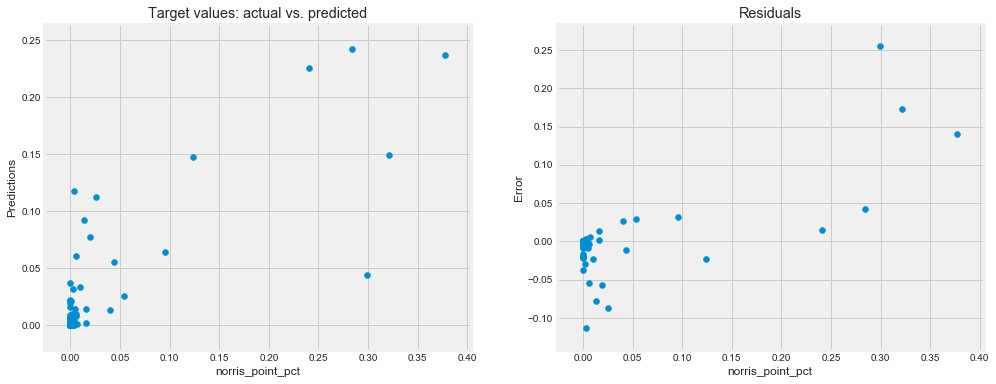

(0.014325608363353374, 0.014730556450954753)

In [76]:
validate_test(rf_model, X_train_all_stats, X_test_all_stats, y_train_all_stats, y_test_all_stats)

#### Gradient Boost

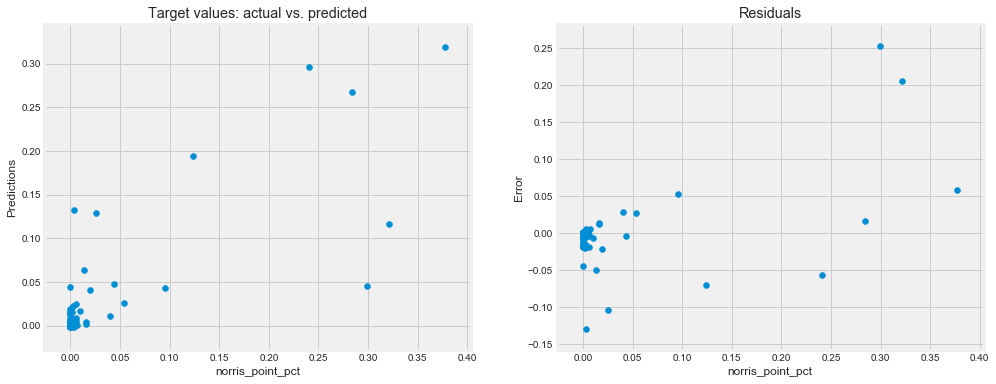

(0.014011370250745623, 0.014704851610170268)

In [77]:
validate_test(gb_model, X_train_all_stats, X_test_all_stats, y_train_all_stats, y_test_all_stats)

Interestingly, test set RMSE scores got slightly worse for both `DecisionTreeRegressor` and `GradientBoostingRegressor` as compared to the models trained on the prior version of our dataset (though, again, we're working with a significantly smaller dataset now; which is very noticeable in our plots).

## Making Predictions For The 2019-2020 Season

There is more we could do to try and improve predictive performance; but, for now, let's move on to making some predictions on the current season's data.

In balancing both overall model performance and maintaining a reasonably substantial historical dataset to work with; we'll make our predictions using the `GradientBoostingRegressor` algorithm (again, with default parameter values, for now), trained on the `past_X_toi` dataframe (which includes time-on-ice/average time-on-ice but not hits or blocked shots, and begins at the 1998-1999 season).

We'll filter the current season's data to contain the same columns as `past_X_toi`, and preprocess both dataframes similarly to how the `tree_preprocess` function did, using integer encoding for the team column.

In [78]:
# drop columns with null values from past_X_toi
past_X_toi = past_X_toi.dropna(axis = 1)

# filter data for current season down to same columns as the training data
current_X = current_season_data[past_X_toi.columns]

# encode `team` column for training and current season data
lenc = LabelEncoder()
lenc.fit(past_X_toi["team"])
past_X_toi["team"] = lenc.transform(past_X_toi["team"])
current_X["team"] = lenc.transform(current_X["team"])

current_X.head()

,age,team,games_played,goals,assists,points,plus_minus,penalty_minutes,point_share,even_strength_goals,power_play_goals,shorthanded_goals,game_winning_goals,even_strength_assists,power_play_assists,shorthanded_assists,shots,shooting_pct,total_toi,avg_toi,team_standings_pts,goals_per_game,goals_per_60,assists_per_game,assists_per_60,points_per_game,points_per_60
10453,0.208333,13,0.942857,0.25,0.600000,0.546667,0.641026,0.250000,0.587719,0.357143,0.000000,0.0,0.166667,0.805556,0.230769,0.333333,0.565385,0.034,0.833424,0.868267,0.639344,0.223881,0.116959,0.537313,0.280702,0.458955,0.239766
10454,0.458333,1,0.328571,0.00,0.016667,0.013333,0.500000,0.000000,0.096491,0.000000,0.000000,0.0,0.000000,0.027778,0.000000,0.000000,0.042308,0.000,0.161693,0.414855,0.573770,0.000000,0.000000,0.041667,0.039867,0.031250,0.029900
10455,0.041667,8,0.571429,0.20,0.150000,0.173333,0.448718,0.057692,0.219298,0.285714,0.000000,0.0,0.166667,0.194444,0.076923,0.000000,0.192308,0.080,0.359197,0.574761,0.540984,0.292683,0.216541,0.219512,0.162406,0.237805,0.175940
10456,0.125000,20,0.985714,0.40,0.566667,0.560000,0.769231,0.307692,0.692982,0.500000,0.142857,0.0,0.666667,0.611111,0.461538,0.000000,0.480769,0.064,0.716224,0.691304,0.655738,0.342857,0.217687,0.485714,0.308390,0.450000,0.285714
10457,0.375000,12,0.685714,0.05,0.083333,0.080000,0.487179,0.336538,0.201754,0.071429,0.000000,0.0,0.000000,0.138889,0.000000,0.000000,0.234615,0.016,0.525773,0.732032,0.721311,0.061224,0.037037,0.102041,0.061728,0.091837,0.055556


In [79]:
# instantiate GBR and fit
gbr = GradientBoostingRegressor(random_state = 1)
gbr.fit(past_X_toi, past_y_toi)

# make predictions on current season's data
current_predictions = gbr.predict(current_X)

# add prediction values as column, and display sorted descending
current_season_filtered["predicted_point_pct"] = current_predictions
current_season_filtered[["name", "predicted_point_pct"]].sort_values(by="predicted_point_pct", ascending=False).head(10)

,name,predicted_point_pct
10699,Roman Josi,0.317796
10588,John Carlson,0.299571
10462,Alex Pietrangelo,0.121770
10754,Zach Werenski,0.095523
10562,Ivan Provorov,0.060170
10743,Victor Hedman,0.059516
10618,Kris Letang,0.051819
10489,Brent Burns,0.033876
10538,Dougie Hamilton,0.030499
10726,Thomas Chabot,0.025462


Our model projects a win for the Nashville Predators' team captain Roman Josi, though our model's predictions could be more appropriately described as roughly a neck-and-neck competition between Josi and John Carlson, who appear to have separated themselves from the rest of the league's defensemen.

__UPDATE 7/20/20__: The National Hockey League [announced the three finalists for the Norris Trophy](https://www.nhl.com/news/john-carlson-victor-hedman-roman-josi-norris-trophy-finalists/) as being Roman Josi, John Carlson, and Victor Hedman.  While our model places Victor Hedman lower than third in the vote share predictions, it does capture Roman Josi and John Carlson as the top two.

__UPDATE 9/21/20__: The [final results were announced](https://nhl.nbcsports.com/2020/09/21/predators-defenseman-roman-josi-wins-2020-norris-trophy-over-carlson-hedman/) with Roman Josi edging out John Carlson for the trophy win.  The top 5 in voting were as such:


| Place | Name | Vote Points | Points % |
|---|---|---|---|
|1|Roman Josi|1499|0.3393|
|2|John Carlson|1267|0.2868|
|3|Victor Hedman|820|0.1856|
|4|Alex Pietrangelo|527|0.1193|
|5|Jaccob Slavin|138|0.0312|

Interestingly, we can see that point percentages were quite close to predicted values for Josi, Carlson, and Pietrangelo; while our model didn't predict voting for Victor Hedman nearly as closely, and didn't include Jaccob Slavin in the top 10 at all.

## Next Steps

There are a variety of additional steps that could be taken going forward, including:

- Hyperparameter optimization for tree-based algorithms used
- Spot checking of a wider range of algorithms and deeper dive into highest performing (i.e. using grid-search)
- Looking more closely into outliers & attempting to establish what features could be engineered or modified to reduce them
- Incorporating more modern advanced hockey metrics and assessing their impact on model performance